# Testing notebook for nifty fit on atmosphere TODs directly (no image)

# Try to add a nifty model for sampling the input map

numpy version: 2.1.1


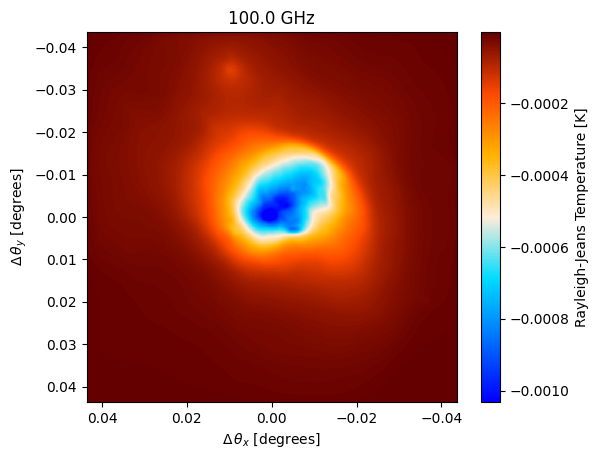

In [1]:
import numpy as np
print(f"numpy version: {np.__version__}")
import matplotlib.pyplot as plt
import maria
import sys
import os

# Relative import of sample_maps for now
sys.path.append(os.path.abspath('../python'))
import mapsampling_jax
from mapsampling_jax import sample_maps

map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=-8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

input_map.to(units="K_RJ").plot()

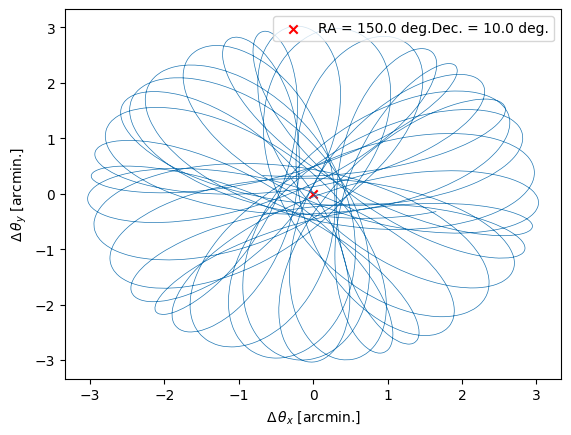

In [2]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                      # duration=300, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

2024-10-08 12:49:11.533 INFO: Constructed instrument.
2024-10-08 12:49:11.534 INFO: Constructed plan.
2024-10-08 12:49:11.535 INFO: Constructed site.
2024-10-08 12:49:12.135 INFO: Constructed boresight.
2024-10-08 12:49:12.975 INFO: Constructed offsets.


Initialized base in 1442 ms.


Generating noise: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]
Generating atmosphere: 4it [00:01,  3.92it/s]
Sampling map (m2/f093): 100%|██████████| 1/1 [00:07<00:00,  7.15s/it]


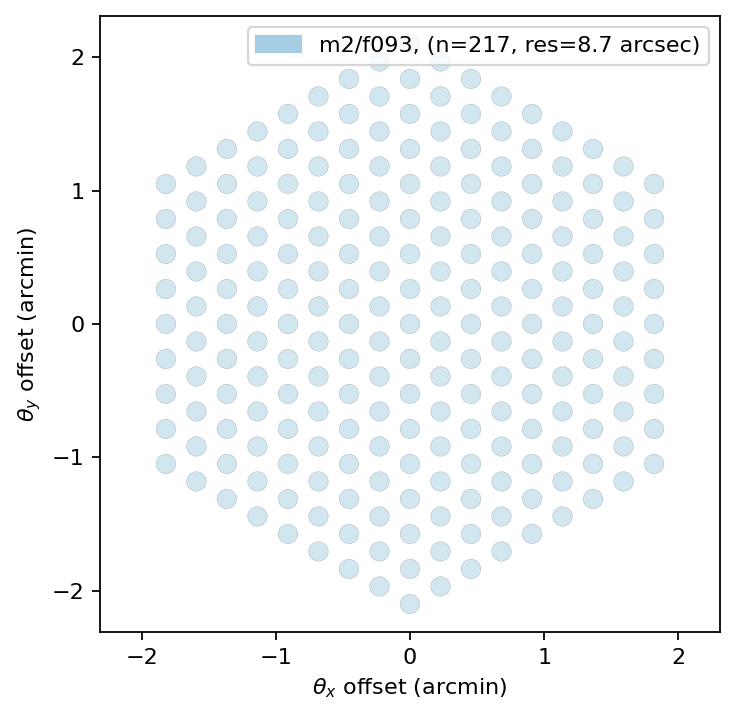

In [3]:
# instrument = maria.get_instrument('MUSTANG-2')
instrument = mapsampling_jax.instrument
instrument.plot()

sim_truthmap = maria.Simulation(instrument, 
                                plan=plan,
                                site="llano_de_chajnantor", 
                                map=input_map,
                                # noise=False,
                                atmosphere="2d",
                                # cmb="generate",
                                )

tod_truthmap = sim_truthmap.run()

In [4]:
dx, dy = sim_truthmap.coords.offsets(frame=sim_truthmap.map.frame, center=sim_truthmap.map.center)
dx = dx.compute()
dy = dy.compute()

dx

array([[-1.96311525e-04, -1.92948912e-04, -1.90091664e-04, ...,
         4.73523479e-04,  4.76548186e-04,  4.80004742e-04],
       [-2.45439384e-04, -2.42077019e-04, -2.39220012e-04, ...,
         4.28168711e-04,  4.31193157e-04,  4.34649406e-04],
       [-1.21122676e-04, -1.17760122e-04, -1.14902918e-04, ...,
         5.49400973e-04,  5.52425644e-04,  5.55882157e-04],
       ...,
       [ 1.21522517e-04,  1.24887173e-04,  1.27746390e-04, ...,
         7.60484074e-04,  7.63510910e-04,  7.66969968e-04],
       [-4.04799431e-04, -4.01434360e-04, -3.98574837e-04, ...,
         2.29341614e-04,  2.32368701e-04,  2.35828064e-04],
       [-7.45700339e-04, -7.42337867e-04, -7.39480837e-04, ...,
        -7.24510214e-05, -6.94266221e-05, -6.59704184e-05]])

Running mapper (m2/f093): 100%|██████████| 1/1 [00:05<00:00,  5.98s/it]


mapdata_truth shape: (1, 1000, 1000)
mapdata_truth mean: -8.726028151723567e-05


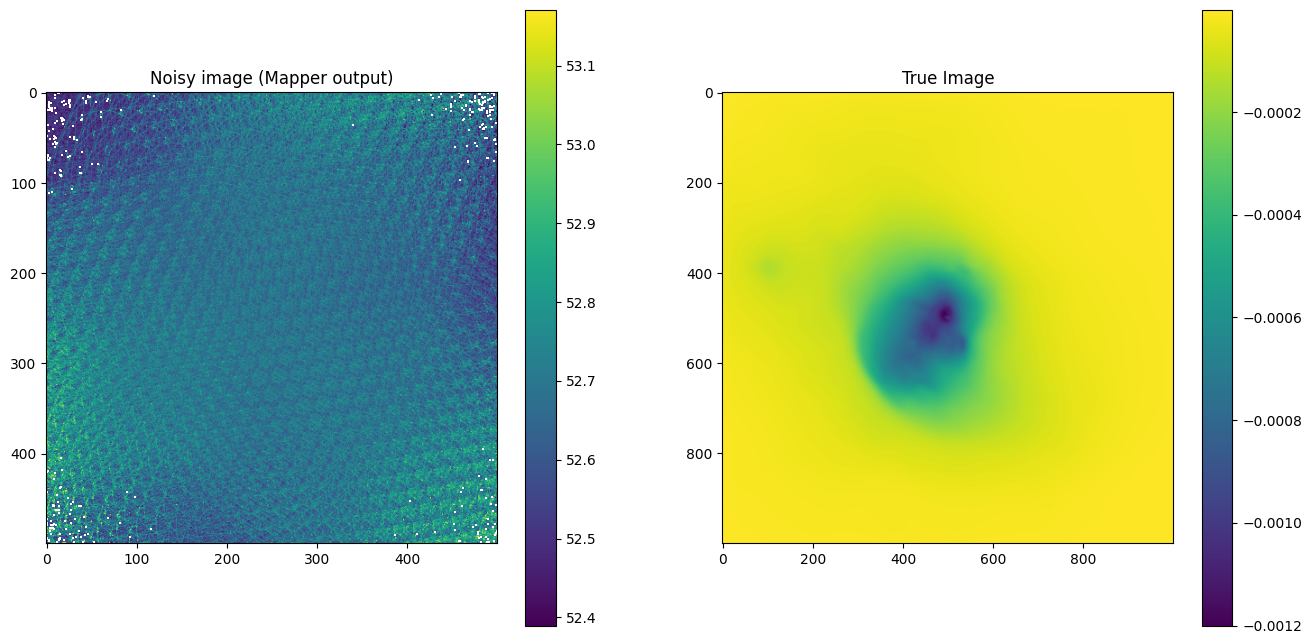

In [5]:
from maria.map.mappers import BinMapper

# Run mapper without any filtering to get noisy mimge
mapper_truthmap = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 0}} )
mapper_truthmap.add_tods(tod_truthmap)
output_truthmap = mapper_truthmap.run()

mapdata_truth = np.float64(sim_truthmap.map.data)
mapdata_truth = np.nan_to_num(mapdata_truth, nan=np.nanmean(mapdata_truth)) # replace nan value by img mean

print("mapdata_truth shape:", mapdata_truth.shape)
print("mapdata_truth mean:", mapdata_truth.mean())

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(output_truthmap.data[0].T)
fig.colorbar(im0)
axes[0].title.set_text("Noisy image (Mapper output)")

im1 = axes[1].imshow(mapdata_truth[0])
fig.colorbar(im1)
axes[1].title.set_text("True Image")

plt.show()

# Re-implement map sampling in JAX for nifty response function:

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import jax
from jax import random
import jax.numpy as jnp

import nifty8.re as jft
import matplotlib.pyplot as plt

import numpy as np

from functools import reduce
from operator import or_

seed = 42
key = random.PRNGKey(seed)

2024-10-08 12:49:37.707 INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-10-08 12:49:37.709 INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


# Test TOD agreement:

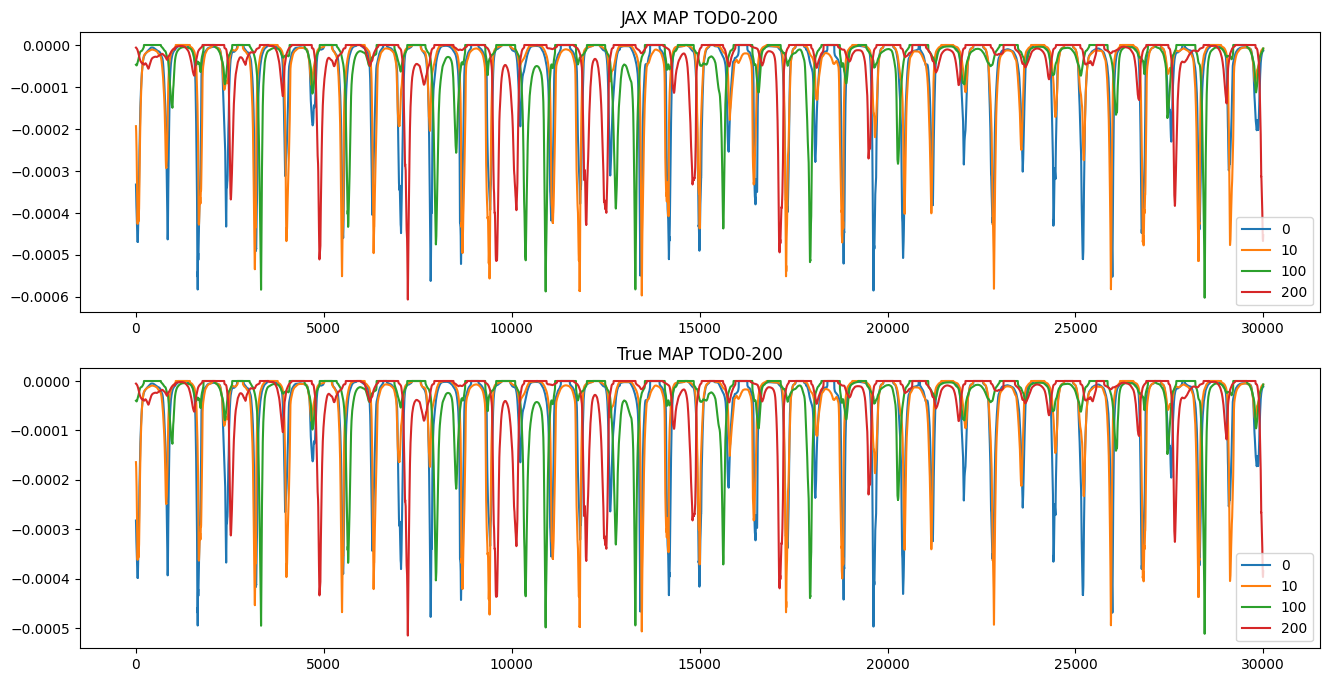

In [7]:
jax_tods_map = sample_maps(mapdata_truth, dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(jax_tods_map[i], label=i)

    tods_map = np.float64(tod_truthmap.components['map'].compute())
    im1 = axes[1].plot(tods_map[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'True MAP TOD0-{i}')
axes[1].legend()

plt.show()

# Smooth atmosphere TODs:

In [8]:
import scipy as sp

jax_tods_atmos = tod_truthmap.components['atmosphere']
jax_tods_atmos_smooth = np.zeros(jax_tods_atmos.shape)

for i in range(jax_tods_atmos.shape[0]):
    jax_tods_atmos_smooth[i] = sp.ndimage.gaussian_filter1d(jax_tods_atmos[i], sigma=2e2)

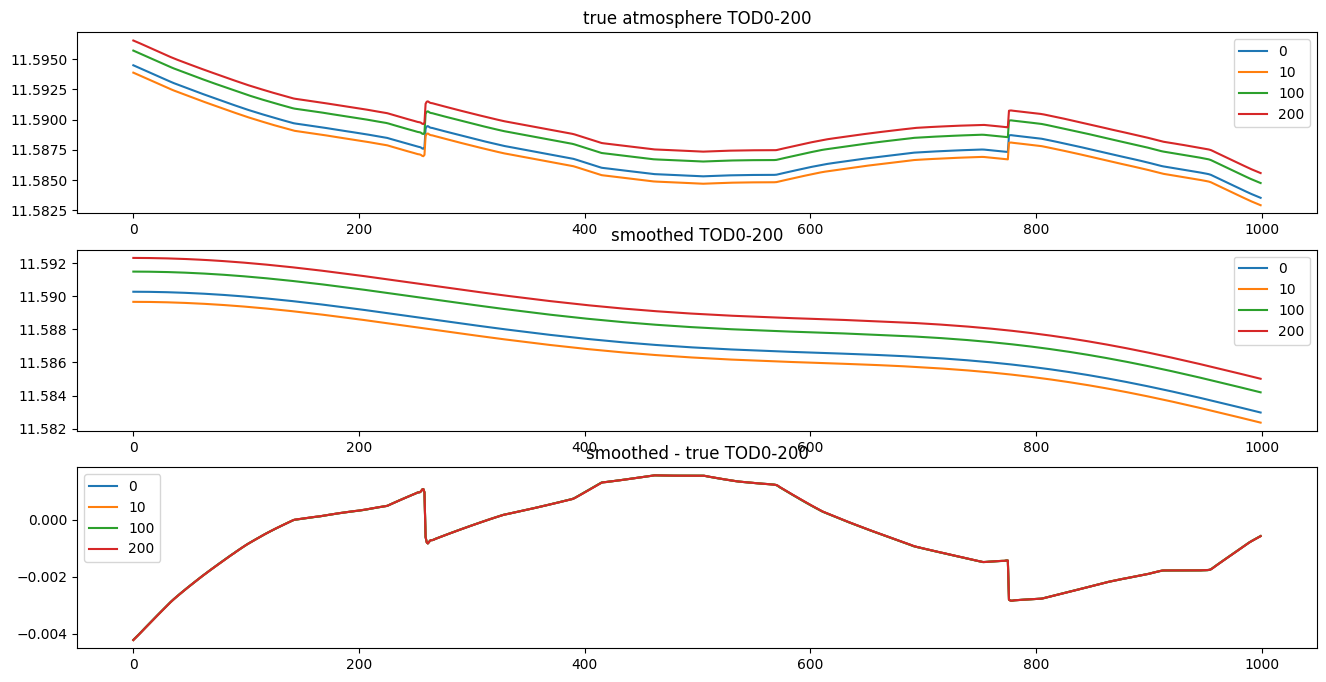

In [9]:
# plot smoothed atmos:

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(jax_tods_atmos[i, 0:1000], label=i)
    im1 = axes[1].plot(jax_tods_atmos_smooth[i, 0:1000], label=i)
    im2 = axes[2].plot(jax_tods_atmos_smooth[i, 0:1000] - jax_tods_atmos[i, 0:1000], label=i)
    
axes[0].title.set_text(f'true atmosphere TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'smoothed TOD0-{i}')
axes[1].legend()
axes[2].title.set_text(f'smoothed - true TOD0-{i}')
axes[2].legend()

plt.show()

# Prepare noised input TODs:

Noise stddev: 0.00025151664


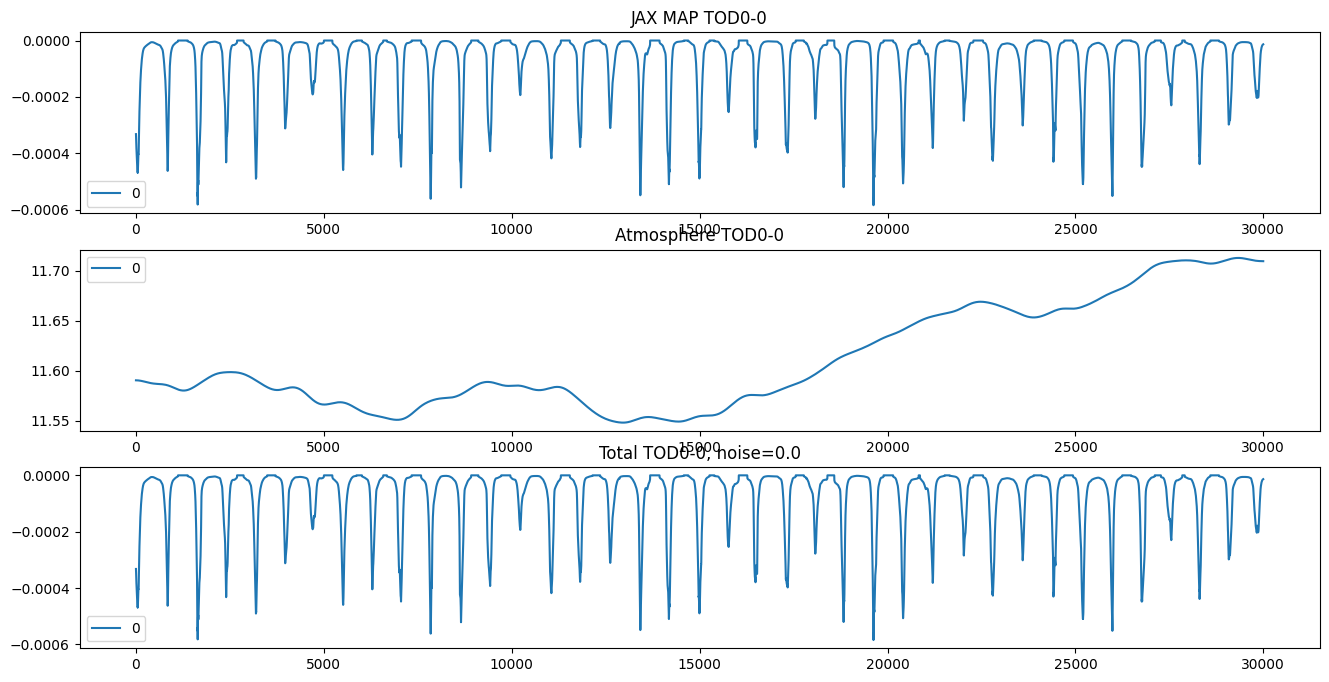

In [10]:
# Pick noise level for rest of run:
noiselevel = 0.0
# noiselevel = 0.1
# noiselevel = 0.5
# noiselevel = 1.0

# Add n TODs for atmos:
n = 1
# n = noised_jax_tod.shape[0]

jax_tods_atmos = tod_truthmap.components['atmosphere']
# noised_jax_tod = np.float64(jax_tods_map) + np.float64(jax_tods_atmos) + np.float64(tod_truthmap.components['noise']*noiselevel)

noised_jax_tod = np.float64(jax_tods_map) + np.float64(tod_truthmap.components['noise']*noiselevel)
# noised_jax_tod[:n] += np.float64(jax_tods_atmos[:n]) 
# noised_jax_tod[:n] = np.float64(jax_tods_atmos_smooth[:n])

print("Noise stddev:", np.std(tod_truthmap.components['noise'].compute()))

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

# for i in [0, 10, 100, 200]:
for i in [0]:
    im0 = axes[0].plot(jax_tods_map[i], label=i)
    # im1 = axes[1].plot(jax_tods_atmos[i], label=i)
    im1 = axes[1].plot(jax_tods_atmos_smooth[i], label=i)
    im2 = axes[2].plot(noised_jax_tod[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'Atmosphere TOD0-{i}')
axes[1].legend()
axes[2].title.set_text(f'Total TOD0-{i}, noise={noiselevel}')
axes[2].legend()

plt.show()

# Next, initialise nifty prior model

Start with the atmosphere TOD model:

In [11]:
dims_atmos = (jax_tods_atmos.shape[1] + 2000,)
padding_atmos = dims_atmos[0] - jax_tods_atmos.shape[1]

# correlated field zero mode GP offset and stddev
# cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.001, 0.1))
cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.0005, 0.001))

# correlated field fluctuations (mostly don't need tuning)
# fluctuations: y-offset in power spectrum in fourier space (zero mode)
# loglogavgslope: power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
# flexibility=(1.5e0, 5e-1), # deviation from simple power-law
# asperity=(5e-1, 5e-2), # small scale features in power-law
cf_fl_tod = dict(
    fluctuations=(0.005, 0.005), 
    loglogavgslope=(-3, 0.5), 
    flexibility=None,
    asperity=None,
)

# put together in correlated field model
cfm_tod = jft.CorrelatedFieldMaker("")
cfm_tod.set_amplitude_total_offset(**cf_zm_tod)
cfm_tod.add_fluctuations(
    dims_atmos, distances=1.0 / dims_atmos[0], **cf_fl_tod, prefix="tod ", non_parametric_kind="power"
)
# gp_tod = cfm_tod.finalize()

## Add one Correlated field per TOD with shared flucts and zero-mean

In [12]:
# init params for each TOD:

gps_tods = []
for i in range(n):
    cfmi = jft.CorrelatedFieldMaker(f'tod{i} ')
    # cfmi.set_amplitude_total_offset(**cf_zm_tod)
    cfmi._azm = cfm_tod._azm
    cfmi._offset_mean = cfm_tod._offset_mean
    cfmi._parameter_tree['zeromode'] = jft.ShapeWithDtype(())

    cfmi._fluctuations.append(cfm_tod._fluctuations[0])
    cfmi._target_grids.append(cfm_tod._target_grids[0])
    cfmi._parameter_tree.update(cfm_tod._fluctuations[0].domain)
    gps_tods.append(cfmi.finalize())

## Now for the map model:

In [39]:
dims_map = (1000, 1000)

# Map model

# correlated field zero mode GP offset and stddev
# cf_zm_map = dict(offset_mean=mapdata_truth.mean(), offset_std=(1e-7, 1e-6))
cf_zm_map = dict(offset_mean=mapdata_truth.mean(), offset_std=(1e-8, 1e-7))
# correlated field fluctuations (mostly don't need tuning)
cf_fl_map = dict(
    fluctuations=(1e-6, 1e-6), # fluctuations: y-offset in power spectrum in fourier space (zero mode)
    loglogavgslope=(-2.5e0, 5e-1), # power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
    flexibility=None,
    asperity=None,
    # flexibility=(1.5e0, 5e-1), # deviation from simple power-law
    # asperity=(5e-1, 5e-2), # small scale features in power-law
)

# put together in correlated field model
cfm_map = jft.CorrelatedFieldMaker("cfmap")
cfm_map.set_amplitude_total_offset(**cf_zm_map)
cfm_map.add_fluctuations(
    dims_map, distances=1.0 / dims_map[0], **cf_fl_map, prefix="ax1", non_parametric_kind="power"
)
gp_map = cfm_map.finalize()

In [40]:
# # only tod:
# class Signal_TOD(jft.Model):
#     def __init__(self, gps_tods):
#         # self.gp_tod = gp_tod
#         # super().__init__(init=self.gp_tod.init, domain=jft.Vector(gp_tod.domain))
#         self.gps_tods = gps_tods
#         self.tgt = (len(gps_tods), gps_tods[0].target.size)
#         # self.gp_map = gp_map
#         # super().__init__(init=reduce(or_, [gp.init for gp in gps_tods] + [gp_map.init]), domain=reduce(or_, [gp.domain for gp in gps_tods] + [gp_map.domain]))
#         super().__init__(init=reduce(or_, [gp.init for gp in gps_tods]), domain=reduce(or_, [gp.domain for gp in gps_tods]))
    
#     def __call__(self, x):
#         res_tods = jnp.zeros(self.tgt)
#         for i, gp in enumerate(self.gps_tods):
#             res_tods = res_tods.at[i].set(gp(x))
        
#         return res_tods[:, padding_atmos//2:-padding_atmos//2]

#         # res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims_map[0], dims_map[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

#         # # Only add first n atmosphere tods, otherwise use map
#         # modified_res_map = res_map.at[:n, :].add(res_tods[:, padding_atmos//2:-padding_atmos//2])

#         # return modified_res_map

# signal_response_tod = Signal_TOD(gps_tods)

In [41]:
# Define simple signal model with added map sampling
# class Signal_TOD(jft.Model):
#     def __init__(self, gps_tods, gp_map):
#         # self.gp_tod = gp_tod
#         # super().__init__(init=self.gp_tod.init, domain=jft.Vector(gp_tod.domain))
#         self.gps_tods = gps_tods
#         self.tgt = (len(gps_tods), gps_tods[0].target.size)
#         self.gp_map = gp_map
#         super().__init__(init=reduce(or_, [gp.init for gp in gps_tods] + [gp_map.init]), domain=reduce(or_, [gp.domain for gp in gps_tods] + [gp_map.domain]))
    
#     def __call__(self, x):
#         res_tods = jnp.zeros(self.tgt)
#         for i, gp in enumerate(self.gps_tods):
#             res_tods = res_tods.at[i].set(gp(x))
        
#         res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims_map[0], dims_map[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

#         # Only add first n atmosphere tods, otherwise use map
#         modified_res_map = res_map.at[:n, :].add(res_tods[:, padding_atmos//2:-padding_atmos//2])

#         return modified_res_map
#         # return res_tods[:, padding_atmos//2:-padding_atmos//2] + res_map
#         # return res_tods[:, padding_atmos//2:-padding_atmos//2] + res_map[:n]

# signal_response_tod = Signal_TOD(gps_tods, gp_map)

# map only:
class Signal_TOD(jft.Model):
    def __init__(self, gp_map):
        # self.gp_tod = gp_tod
        # super().__init__(init=self.gp_tod.init, domain=jft.Vector(gp_tod.domain))
        # self.gps_tods = gps_tods
        # self.tgt = (len(gps_tods), gps_tods[0].target.size)
        self.gp_map = gp_map
        # super().__init__(init=reduce(or_, [gp.init for gp in gps_tods] + [gp_map.init]), domain=reduce(or_, [gp.domain for gp in gps_tods] + [gp_map.domain]))
        super().__init__(init=gp_map.init, domain=gp_map.domain)
    
    def __call__(self, x):
        # res_tods = jnp.zeros(self.tgt)
        # for i, gp in enumerate(self.gps_tods):
        #     res_tods = res_tods.at[i].set(gp(x))
        
        res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims_map[0], dims_map[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
        return res_map

        # Only add first n atmosphere tods, otherwise use map
        # modified_res_map = res_map.at[:n, :].add(res_tods[:, padding_atmos//2:-padding_atmos//2])

        # return modified_res_map
        # return res_tods[:, padding_atmos//2:-padding_atmos//2] + res_map
        # return res_tods[:, padding_atmos//2:-padding_atmos//2] + res_map[:n]
  
signal_response_tod = Signal_TOD(gp_map)

# Define noise covariance
# if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x
if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 1e-8**-2 * x
elif noiselevel == 0.1: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 0.5: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 1.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x

# Combine in likelihood - only fit 0th TOD for now!
# truth = noised_jax_tod[:n]
truth = noised_jax_tod
lh_tod = jft.Gaussian( truth, noise_cov_inv_tod).amend(signal_response_tod)

# lh = lh_tod + lh_map
# lh = lh_map
lh = lh_tod

# lh_map_grad = jax.grad(lh_map)
lh_tod_grad = jax.grad(lh_tod)

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


In [42]:
signal_response_tod

Signal_TOD(
	<bound method Signal_TOD.__call__>,
	domain={'cfmapax1fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'cfmapax1loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'cfmapxi': ShapeWithDtype(shape=(1000, 1000), dtype=<class 'jax.numpy.float64'>),
	 'cfmapzeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)},
	init=Initializer(
		{'cfmapax1fluctuations': functools.partial(<function random_like at 0x7f5251881760>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'cfmapax1loglogavgslope': functools.partial(<function random_like at 0x7f5251881760>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'cfmapxi': functools.partial(<function random_like at 0x7f5251881760>, primals=ShapeWithDtype(shape=(1000, 1000), dtype=<class 'jax.numpy.float64'>)),
		 'cfmapzeromode': functools.partial(<function random_like at 0x7f5251881760>, primals=ShapeWithDtype(shape=(), d

# Draw Prior sample

(217, 30000)


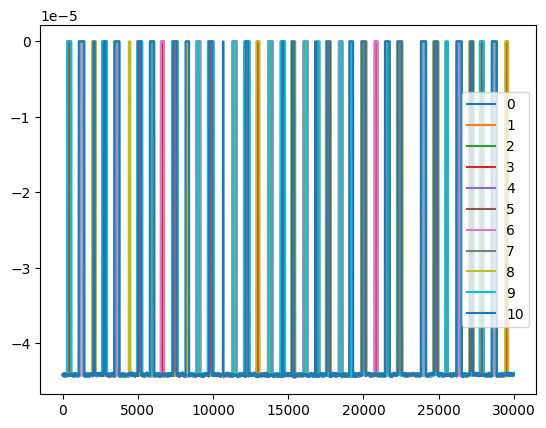

In [43]:
key, sub = jax.random.split(key)
xi = jft.random_like(sub, signal_response_tod.domain)
res = signal_response_tod(xi)
print(res.shape)

# for i in range(res.shape[0]):
for i in range(11):
    plt.plot(np.arange(0, res.shape[1]), res[i], label=i)
plt.legend()
plt.show()

# MAP fit

In [44]:
n_it = 1
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4

n_samples = 0 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60 # map
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=20 # map
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
)

OPTIMIZE_KL: Starting 0001
M: →:0.125 ↺:False #∇²:06 |↘|:2.441010e+03 ➽:1.000003e+02
M: Iteration 1 ⛰:+4.778094e+13 Δ⛰:1.502061e+14
M: →:0.25 ↺:False #∇²:12 |↘|:1.856634e+02 ➽:1.000003e+02
M: Iteration 2 ⛰:+3.483263e+13 Δ⛰:1.294831e+13
M: →:0.25 ↺:False #∇²:18 |↘|:3.735885e+02 ➽:1.000003e+02
M: Iteration 3 ⛰:+3.140954e+13 Δ⛰:3.423096e+12
M: →:0.25 ↺:False #∇²:24 |↘|:5.731061e+02 ➽:1.000003e+02
M: Iteration 4 ⛰:+2.372937e+13 Δ⛰:7.680165e+12
M: →:1.0 ↺:False #∇²:30 |↘|:2.601898e+03 ➽:1.000003e+02
M: Iteration 5 ⛰:+2.224425e+12 Δ⛰:2.150495e+13
M: →:1.0 ↺:False #∇²:36 |↘|:1.139888e+03 ➽:1.000003e+02
M: Iteration 6 ⛰:+2.206261e+12 Δ⛰:1.816332e+10
M: →:1.0 ↺:False #∇²:42 |↘|:1.584761e+03 ➽:1.000003e+02
M: Iteration 7 ⛰:+1.938740e+11 Δ⛰:2.012387e+12
M: →:1.0 ↺:False #∇²:48 |↘|:3.357049e+02 ➽:1.000003e+02
M: Iteration 8 ⛰:+1.469526e+11 Δ⛰:4.692143e+10
M: →:1.0 ↺:False #∇²:54 |↘|:7.424746e+02 ➽:1.000003e+02
M: Iteration 9 ⛰:+1.296317e+11 Δ⛰:1.732089e+10
M: →:1.0 ↺:False #∇²:60 |↘|:2.667042e+02 

In [45]:
samples.pos

Vector(
	{'cfmapax1fluctuations': Array(2.45299687, dtype=float64),
	 'cfmapax1loglogavgslope': Array(0.61877915, dtype=float64),
	 'cfmapxi': Array([[ -1.41084507,  64.09785724, -69.21628003, ...,  -5.25802329,
	        -18.59734458,  29.87142518],
	       [ 39.62392147, -50.00924666,  64.02314609, ...,   9.28351497,
	          3.69902733, -22.13124833],
	       [-20.0360504 ,  33.21558262, -51.08948616, ...,  -5.76716741,
	         12.29008303,   1.29472958],
	       ...,
	       [ 22.36208752, -21.41313421,   6.49951096, ..., -19.46216111,
	         30.23196874, -30.66544407],
	       [-51.92795113,  60.25555431, -39.87405954, ...,  14.82399224,
	        -36.10857093,  44.05732509],
	       [ 56.26430817, -78.62464902,  66.48238587, ...,  -3.6907305 ,
	         29.45721696, -40.88418217]], dtype=float64),
	 'cfmapzeromode': Array(0.59849602, dtype=float64)}
)

In [46]:
def printfitresults():
    print("Fit Results (res, init, std)")

    # print("\nTODs:")
    # print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_tod['fluctuations'])(samples.pos['tod fluctuations'])}, {cf_fl_tod['fluctuations'][0]}, {cf_fl_tod['fluctuations'][1]}")
    # print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_tod['loglogavgslope'])(samples.pos['tod loglogavgslope'])}, {cf_fl_tod['loglogavgslope'][0]}, {cf_fl_tod['loglogavgslope'][1]}")
    # print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_tod['offset_std'])(samples.pos['zeromode'])}, {cf_zm_tod['offset_std'][0]}, {cf_zm_tod['offset_std'][1]}")

    # If custom zeromode per TOD:
    # for i in range(n):
    #     test = samples.pos[f"tod{i} zeromode"]
    #     print(f"tod{i} zeromode: {jft.LogNormalPrior(cf_zm_tod['offset_mean'], cf_zm_tod['offset_std'][0])(test)}, {cf_zm_tod['offset_mean']}, {cf_zm_tod['offset_std'][0]}")
    
    print("map:")
    print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_map['fluctuations'])(samples.pos['cfmapax1fluctuations'])}, {cf_fl_map['fluctuations'][0]}, {cf_fl_map['fluctuations'][1]}")
    print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_map['loglogavgslope'])(samples.pos['cfmapax1loglogavgslope'])}, {cf_fl_map['loglogavgslope'][0]}, {cf_fl_map['loglogavgslope'][1]}")
    print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_map['offset_std'])(samples.pos['cfmapzeromode'])}, {cf_zm_map['offset_std'][0]}, {cf_zm_map['offset_std'][1]}")
    
    
printfitresults()

Fit Results (res, init, std)
map:
	fluctuations: 5.450352376720802e-06, 1e-06, 1e-06
	loglogvarslope: -2.1906104240294373, -2.5, 0.5
	zeromode std (LogNormal): 3.599387708927085e-09, 1e-08, 1e-07


(217, 30000)


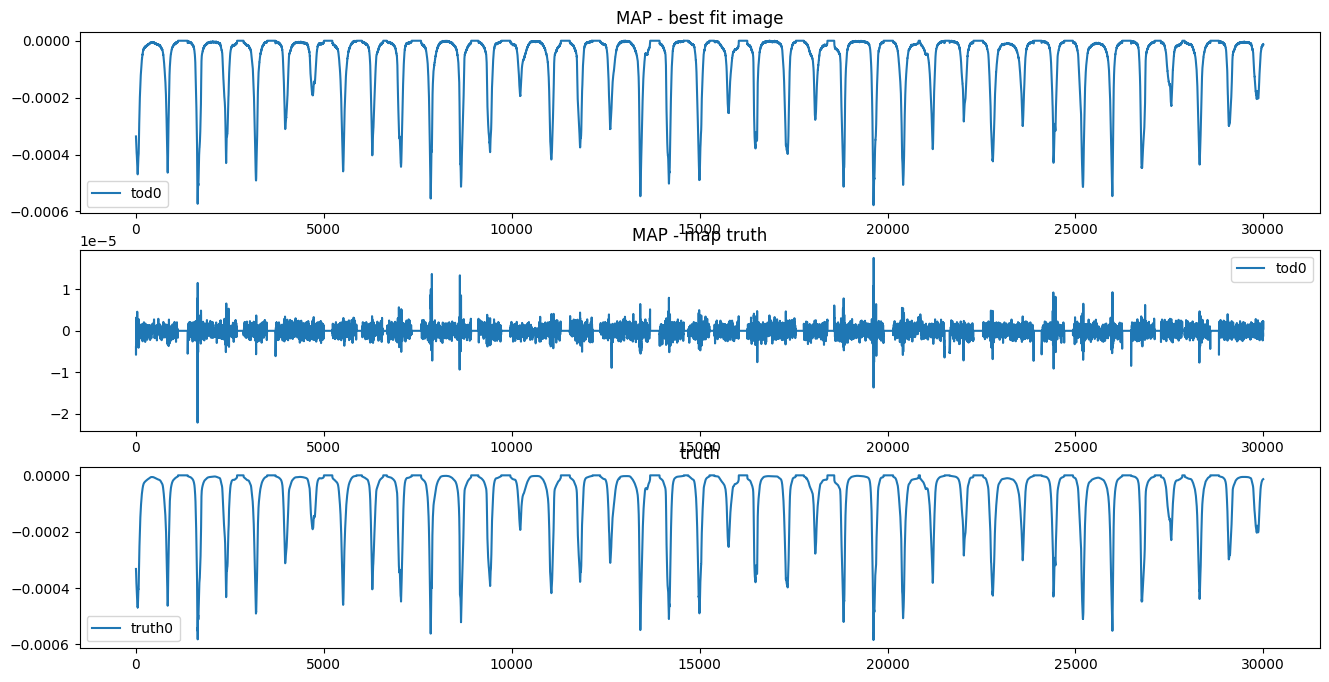

In [47]:
res = signal_response_tod(samples.pos)
print(res.shape)

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

# for i in range(0, res.shape[0], res.shape[0]//10):
for i in range(1):
    im0 = axes[0].plot(np.arange(0, res.shape[1]), res[i], label=f"tod{i}")
    im1 = axes[1].plot(np.arange(0, res.shape[1]), res[i] - truth[i], label=f"tod{i}")
    im2 = axes[2].plot(truth[i], label=f"truth{i}")

axes[0].title.set_text('MAP - best fit image')
axes[0].legend()
axes[1].title.set_text('MAP - map truth')
axes[1].legend()
axes[2].title.set_text('truth')
axes[2].legend()

plt.show()

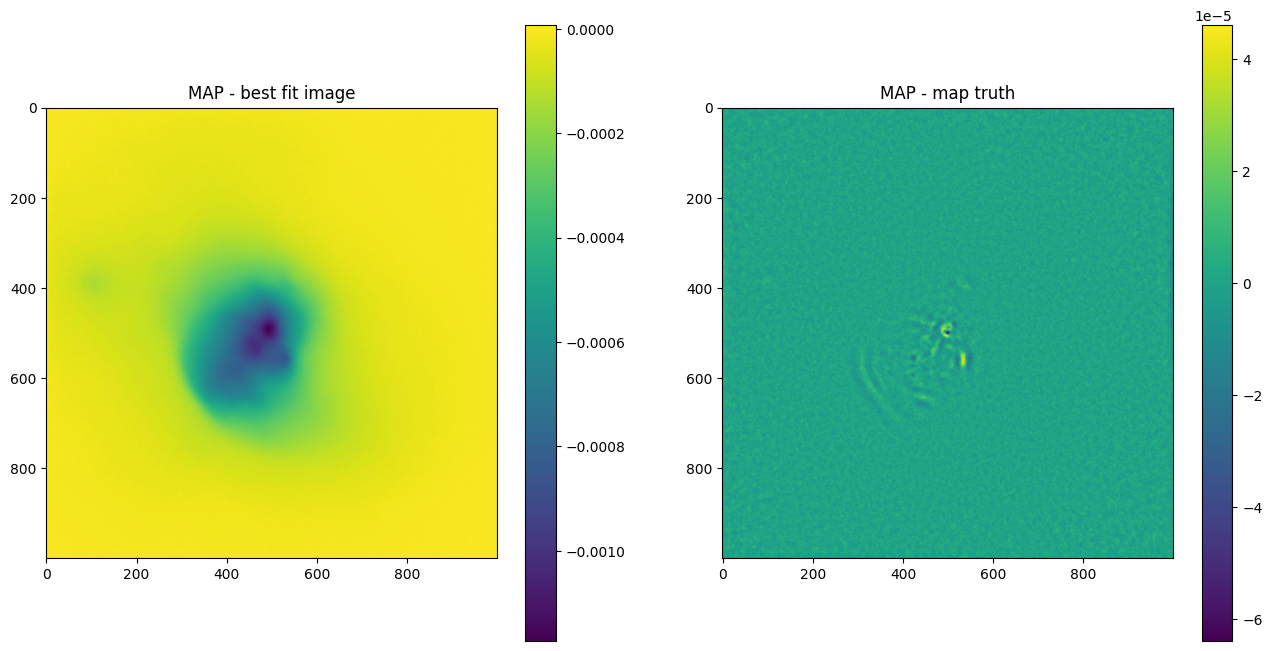

In [48]:
# plot maximum of posterior (mode)
# sig_map = signal_response(samples.pos) # gives time-series
sig_map = gp_map(samples.pos) # when splitting up in different field models

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(sig_map)
axes[0].title.set_text('MAP - best fit image')
fig.colorbar(im0)

im1 = axes[1].imshow( sig_map - mapdata_truth[0] )
axes[1].title.set_text('MAP - map truth')
# im1 = axes[1].imshow( (sig_map - mapdata_truth) )
# axes[1].title.set_text('diff prediction - map truth')
fig.colorbar(im1)

plt.show()

In [37]:
# assert False

## Full nifty fit:

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:+3.8376e+09 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:+2.4182e+09 Δ⛰:1.4194e+09 ➽:1.0000e+01
SL: Iteration 2 ⛰:+1.4593e+09 Δ⛰:9.5886e+08 ➽:1.0000e+01
SL: Iteration 3 ⛰:+1.1369e+09 Δ⛰:3.2249e+08 ➽:1.0000e+01
SL: Iteration 4 ⛰:+1.0022e+09 Δ⛰:1.3463e+08 ➽:1.0000e+01
SL: Iteration 5 ⛰:+7.8599e+08 Δ⛰:2.1624e+08 ➽:1.0000e+01
SL: Iteration 6 ⛰:+7.2815e+08 Δ⛰:5.7838e+07 ➽:1.0000e+01
SL: Iteration 7 ⛰:+6.4453e+08 Δ⛰:8.3619e+07 ➽:1.0000e+01
SL: Iteration 8 ⛰:+5.5580e+08 Δ⛰:8.8736e+07 ➽:1.0000e+01
SL: Iteration 9 ⛰:+4.9122e+08 Δ⛰:6.4578e+07 ➽:1.0000e+01
SL: Iteration 10 ⛰:+4.6298e+08 Δ⛰:2.8240e+07 ➽:1.0000e+01
SL: Iteration 11 ⛰:+4.4120e+08 Δ⛰:2.1774e+07 ➽:1.0000e+01
SL: Iteration 12 ⛰:+4.3050e+08 Δ⛰:1.0708e+07 ➽:1.0000e+01
SL: Iteration 13 ⛰:+3.8657e+08 Δ⛰:4.3928e+07 ➽:1.0000e+01
SL: Iteration 14 ⛰:+3.6582e+08 Δ⛰:2.0747e+07 ➽:1.0000e+01
SL: Iteration 15 ⛰:+3.4013e+08 Δ⛰:2.5689e+07 ➽:1.0000e+01
SL: Iteration 16 ⛰:+3.1426e+08 Δ⛰:2.5867e+07 ➽:1.0000e+01
SL: 

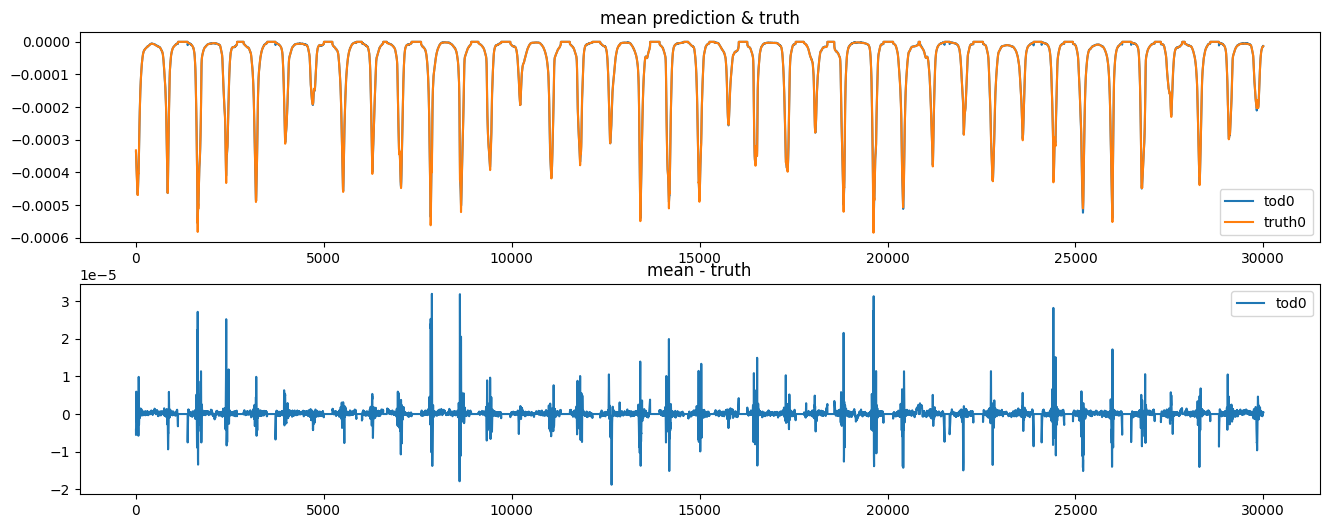

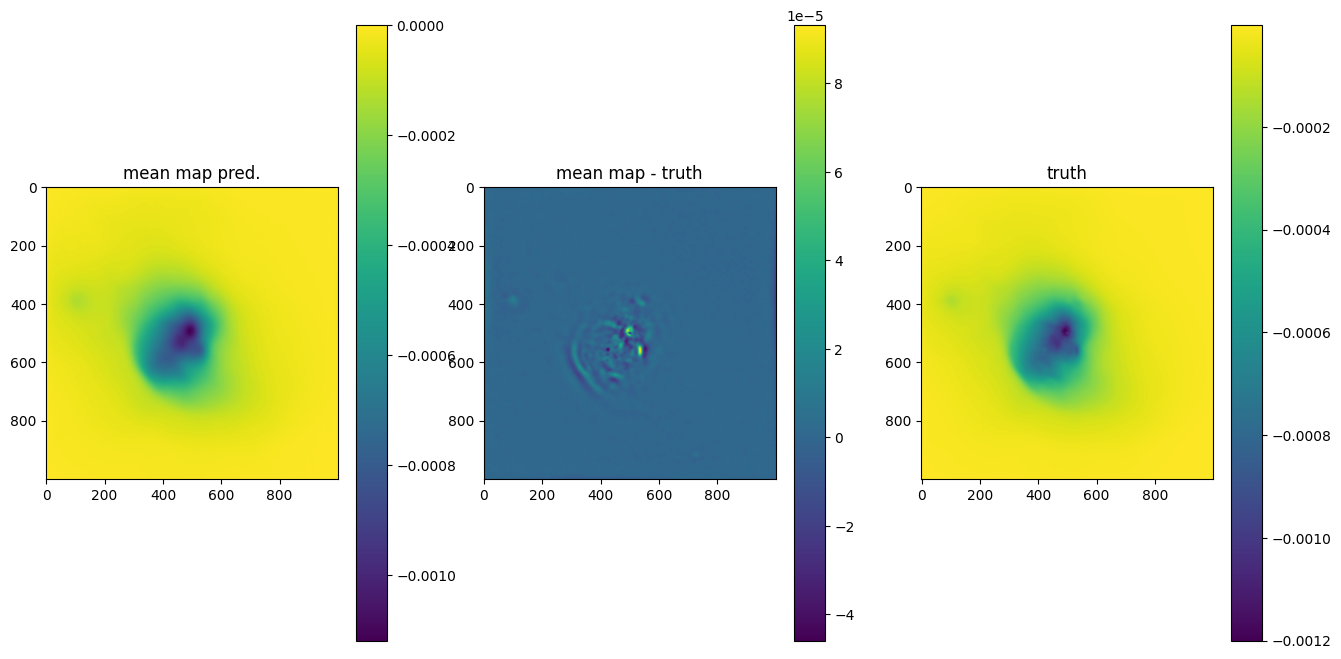

OPTIMIZE_KL: Starting 0002
SL: Iteration 0 ⛰:+1.0428e+12 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:+7.4228e+11 Δ⛰:3.0054e+11 ➽:1.0000e+01
SL: Iteration 2 ⛰:+1.1827e+10 Δ⛰:7.3045e+11 ➽:1.0000e+01
SL: Iteration 3 ⛰:+8.5687e+09 Δ⛰:3.2579e+09 ➽:1.0000e+01
SL: Iteration 4 ⛰:+6.7422e+09 Δ⛰:1.8265e+09 ➽:1.0000e+01
SL: Iteration 5 ⛰:+6.7422e+09 Δ⛰:3.7484e+04 ➽:1.0000e+01
SL: Iteration 6 ⛰:+5.7208e+09 Δ⛰:1.0214e+09 ➽:1.0000e+01
SL: Iteration 7 ⛰:+5.6755e+09 Δ⛰:4.5259e+07 ➽:1.0000e+01
SL: Iteration 8 ⛰:+5.2948e+09 Δ⛰:3.8068e+08 ➽:1.0000e+01
SL: Iteration 9 ⛰:+5.2944e+09 Δ⛰:4.5157e+05 ➽:1.0000e+01
SL: Iteration 10 ⛰:+4.6301e+09 Δ⛰:6.6427e+08 ➽:1.0000e+01
SL: Iteration 11 ⛰:+4.0958e+09 Δ⛰:5.3434e+08 ➽:1.0000e+01
SL: Iteration 12 ⛰:+3.9568e+09 Δ⛰:1.3892e+08 ➽:1.0000e+01
SL: Iteration 13 ⛰:+3.9568e+09 Δ⛰:6.9610e+04 ➽:1.0000e+01
SL: Iteration 14 ⛰:+3.9566e+09 Δ⛰:1.4965e+05 ➽:1.0000e+01
SL: Iteration 15 ⛰:+3.6317e+09 Δ⛰:3.2496e+08 ➽:1.0000e+01
SL: Iteration 16 ⛰:+3.3934e+09 Δ⛰:2.3826e+08 ➽:1.0000e+01
SL: 

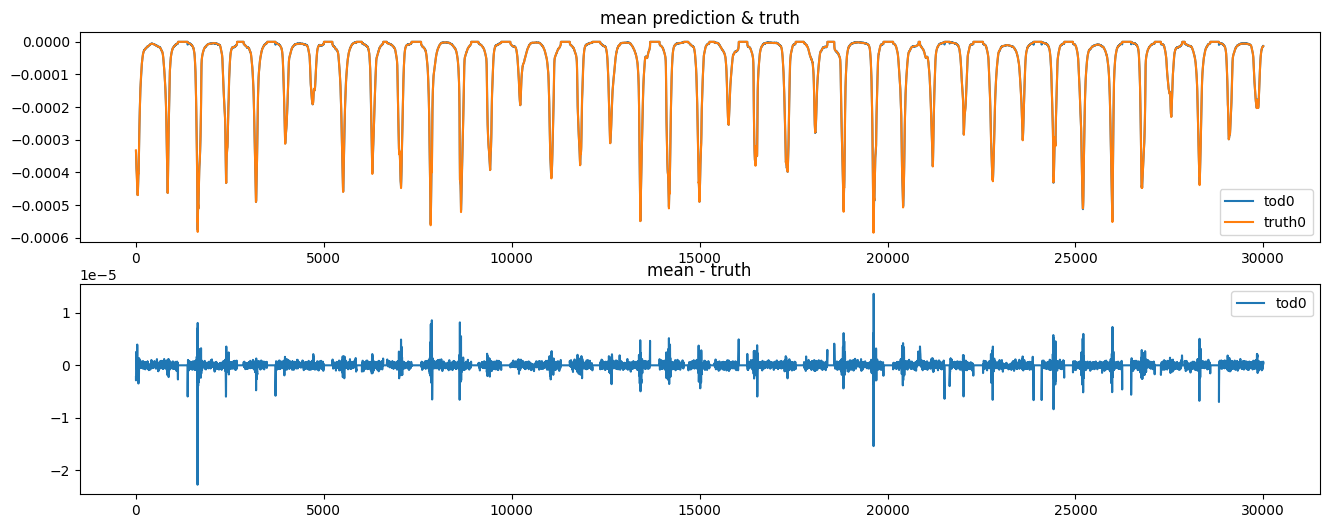

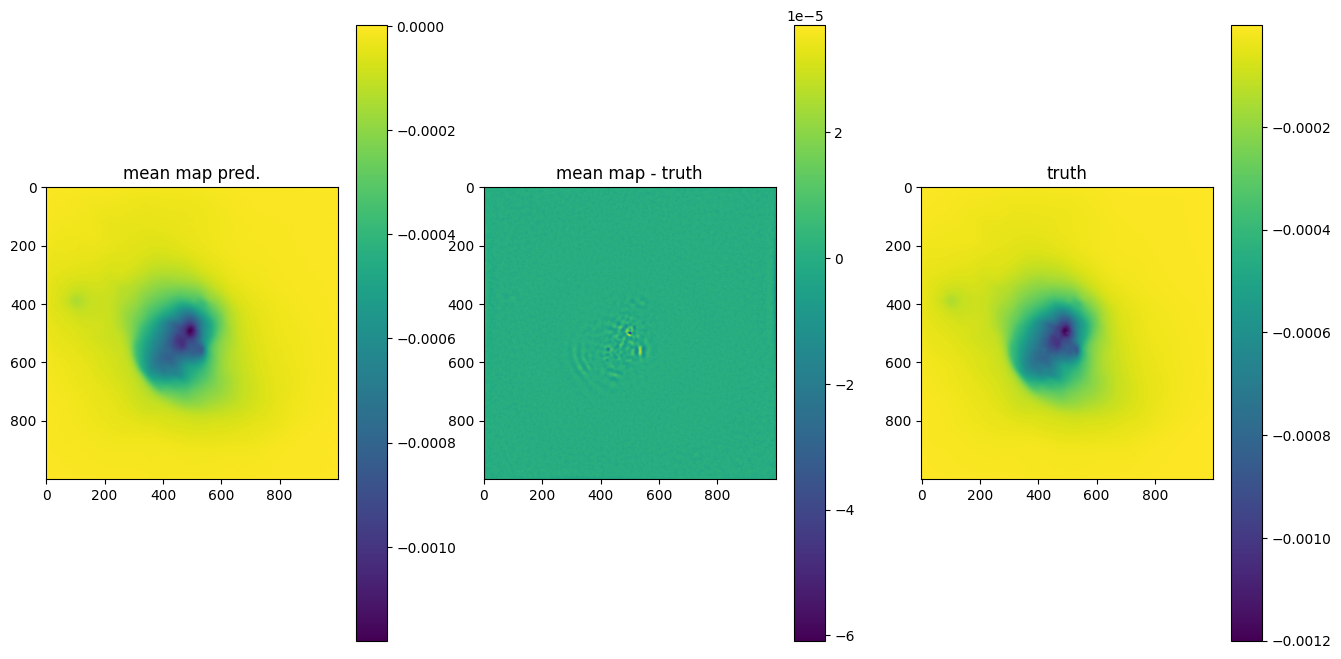

OPTIMIZE_KL: Starting 0003
SL: Iteration 0 ⛰:+9.1212e+13 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:+1.4884e+12 Δ⛰:8.9724e+13 ➽:1.0000e+01
SL: Iteration 2 ⛰:+1.8017e+10 Δ⛰:1.4704e+12 ➽:1.0000e+01
SL: Iteration 3 ⛰:+1.3374e+10 Δ⛰:4.6430e+09 ➽:1.0000e+01
SL: Iteration 4 ⛰:+1.1698e+10 Δ⛰:1.6759e+09 ➽:1.0000e+01
SL: Iteration 5 ⛰:+1.0357e+10 Δ⛰:1.3411e+09 ➽:1.0000e+01
SL: Iteration 6 ⛰:+9.5918e+09 Δ⛰:7.6516e+08 ➽:1.0000e+01
SL: Iteration 7 ⛰:+9.0627e+09 Δ⛰:5.2906e+08 ➽:1.0000e+01
SL: Iteration 8 ⛰:+8.4471e+09 Δ⛰:6.1562e+08 ➽:1.0000e+01
SL: Iteration 9 ⛰:+8.4468e+09 Δ⛰:2.7008e+05 ➽:1.0000e+01
SL: Iteration 10 ⛰:+7.5620e+09 Δ⛰:8.8480e+08 ➽:1.0000e+01
SL: Iteration 11 ⛰:+6.9417e+09 Δ⛰:6.2036e+08 ➽:1.0000e+01
SL: Iteration 12 ⛰:+6.9405e+09 Δ⛰:1.1203e+06 ➽:1.0000e+01
SL: Iteration 13 ⛰:+6.6047e+09 Δ⛰:3.3584e+08 ➽:1.0000e+01
SL: Iteration 14 ⛰:+6.5605e+09 Δ⛰:4.4190e+07 ➽:1.0000e+01
SL: Iteration 15 ⛰:+6.3820e+09 Δ⛰:1.7848e+08 ➽:1.0000e+01
SL: Iteration 16 ⛰:+5.8980e+09 Δ⛰:4.8406e+08 ➽:1.0000e+01
SL: 

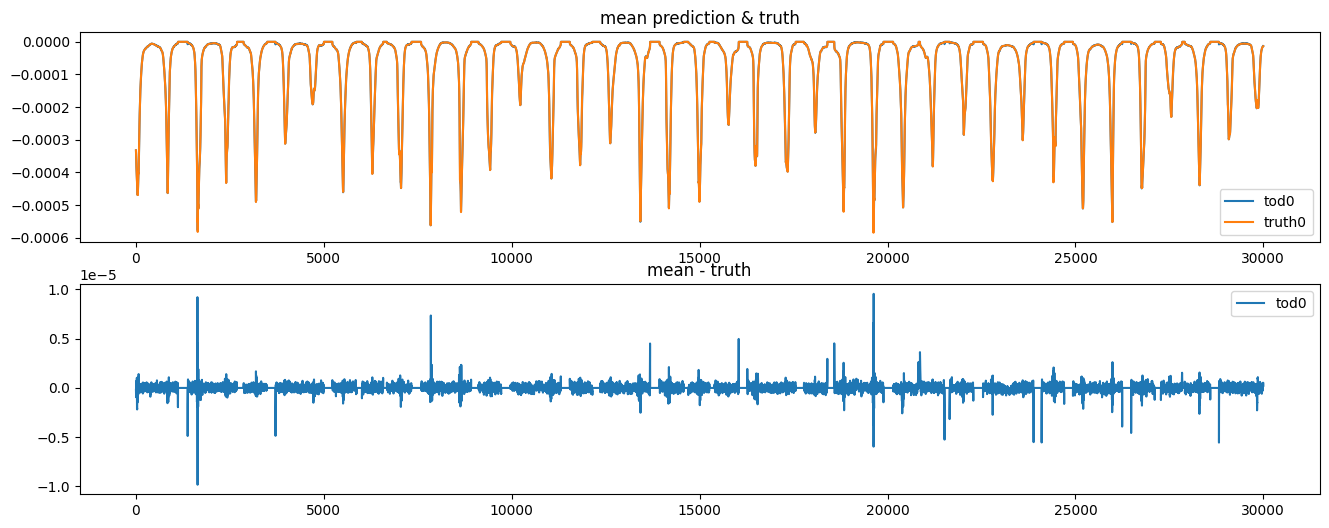

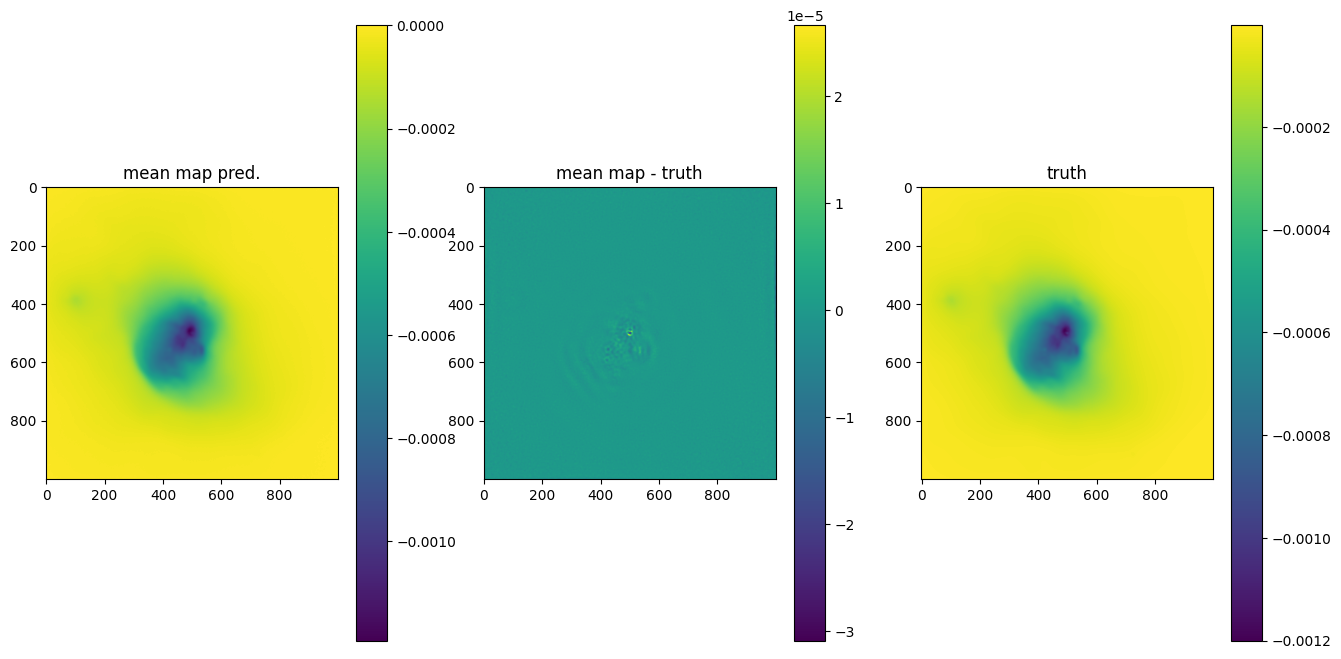

OPTIMIZE_KL: Starting 0004
SL: Iteration 0 ⛰:+8.4706e+12 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:+5.4346e+11 Δ⛰:7.9272e+12 ➽:1.0000e+01
SL: Iteration 2 ⛰:+1.5218e+10 Δ⛰:5.2825e+11 ➽:1.0000e+01
SL: Iteration 3 ⛰:+1.1677e+10 Δ⛰:3.5406e+09 ➽:1.0000e+01
SL: Iteration 4 ⛰:+9.5489e+09 Δ⛰:2.1281e+09 ➽:1.0000e+01
SL: Iteration 5 ⛰:+9.5413e+09 Δ⛰:7.6020e+06 ➽:1.0000e+01
SL: Iteration 6 ⛰:+8.3428e+09 Δ⛰:1.1985e+09 ➽:1.0000e+01
SL: Iteration 7 ⛰:+8.0951e+09 Δ⛰:2.4771e+08 ➽:1.0000e+01
SL: Iteration 8 ⛰:+7.5649e+09 Δ⛰:5.3016e+08 ➽:1.0000e+01
SL: Iteration 9 ⛰:+7.5649e+09 Δ⛰:8.8560e+03 ➽:1.0000e+01
SL: Iteration 10 ⛰:+6.4076e+09 Δ⛰:1.1573e+09 ➽:1.0000e+01
SL: Iteration 11 ⛰:+6.0271e+09 Δ⛰:3.8056e+08 ➽:1.0000e+01
SL: Iteration 12 ⛰:+5.5385e+09 Δ⛰:4.8853e+08 ➽:1.0000e+01
SL: Iteration 13 ⛰:+5.5385e+09 Δ⛰:2.4364e+03 ➽:1.0000e+01
SL: Iteration 14 ⛰:+5.3496e+09 Δ⛰:1.8889e+08 ➽:1.0000e+01
SL: Iteration 15 ⛰:+5.1026e+09 Δ⛰:2.4700e+08 ➽:1.0000e+01
SL: Iteration 16 ⛰:+4.9736e+09 Δ⛰:1.2902e+08 ➽:1.0000e+01
SL: 

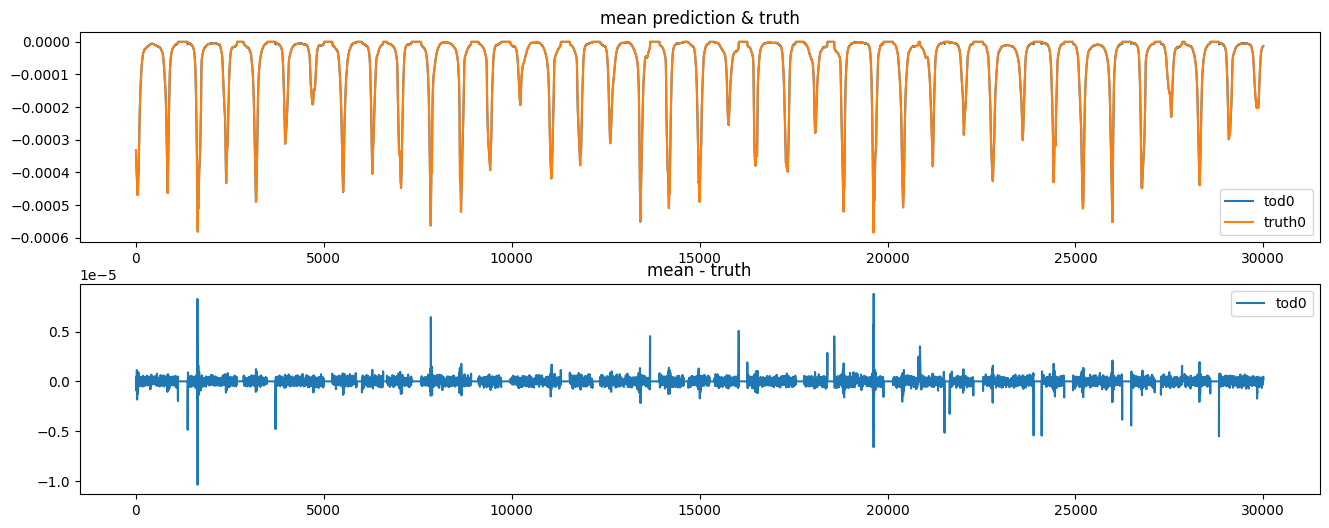

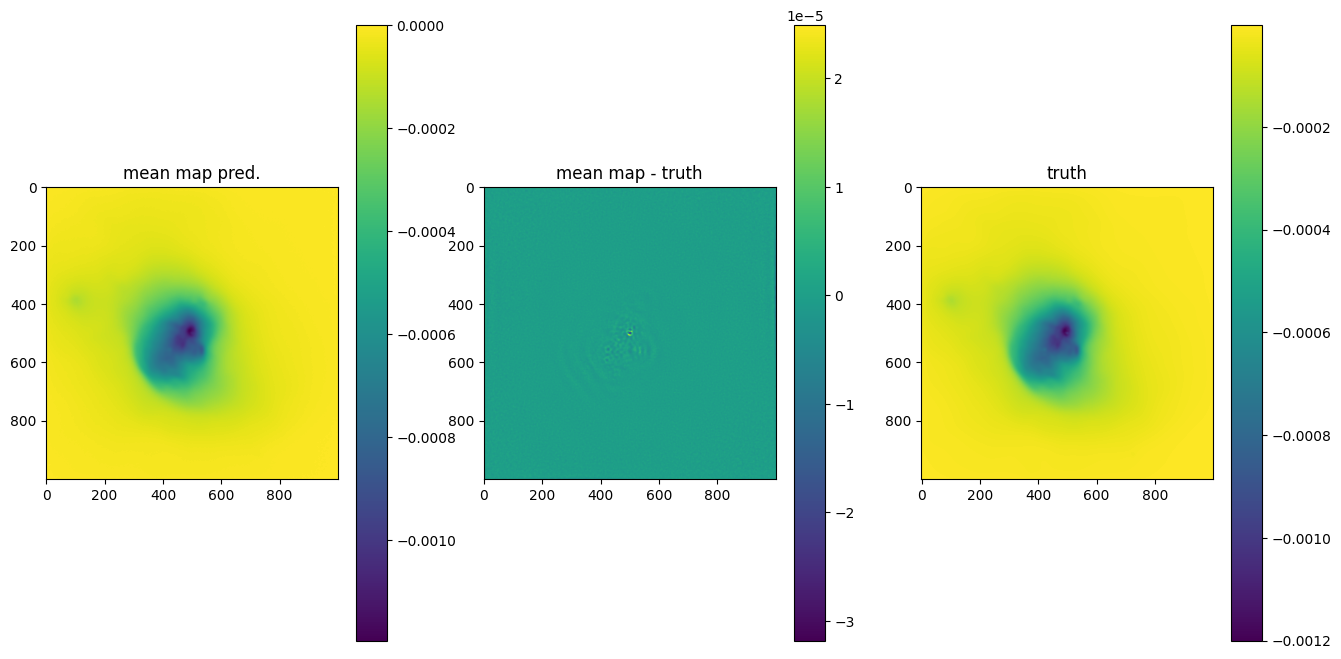

OPTIMIZE_KL: Starting 0005
SL: Iteration 0 ⛰:+3.2036e+12 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:+4.9281e+11 Δ⛰:2.7108e+12 ➽:1.0000e+01
SL: Iteration 2 ⛰:+1.7148e+10 Δ⛰:4.7566e+11 ➽:1.0000e+01
SL: Iteration 3 ⛰:+1.1699e+10 Δ⛰:5.4496e+09 ➽:1.0000e+01
SL: Iteration 4 ⛰:+9.7216e+09 Δ⛰:1.9773e+09 ➽:1.0000e+01
SL: Iteration 5 ⛰:+9.7195e+09 Δ⛰:2.1156e+06 ➽:1.0000e+01
SL: Iteration 6 ⛰:+8.5628e+09 Δ⛰:1.1567e+09 ➽:1.0000e+01
SL: Iteration 7 ⛰:+8.3806e+09 Δ⛰:1.8214e+08 ➽:1.0000e+01
SL: Iteration 8 ⛰:+7.8351e+09 Δ⛰:5.4551e+08 ➽:1.0000e+01
SL: Iteration 9 ⛰:+7.8351e+09 Δ⛰:5.4632e+04 ➽:1.0000e+01
SL: Iteration 10 ⛰:+6.9779e+09 Δ⛰:8.5716e+08 ➽:1.0000e+01
SL: Iteration 11 ⛰:+6.2923e+09 Δ⛰:6.8555e+08 ➽:1.0000e+01
SL: Iteration 12 ⛰:+5.8675e+09 Δ⛰:4.2482e+08 ➽:1.0000e+01
SL: Iteration 13 ⛰:+5.8674e+09 Δ⛰:8.3618e+04 ➽:1.0000e+01
SL: Iteration 14 ⛰:+5.7190e+09 Δ⛰:1.4841e+08 ➽:1.0000e+01
SL: Iteration 15 ⛰:+5.6297e+09 Δ⛰:8.9374e+07 ➽:1.0000e+01
SL: Iteration 16 ⛰:+5.3326e+09 Δ⛰:2.9707e+08 ➽:1.0000e+01
SL: 

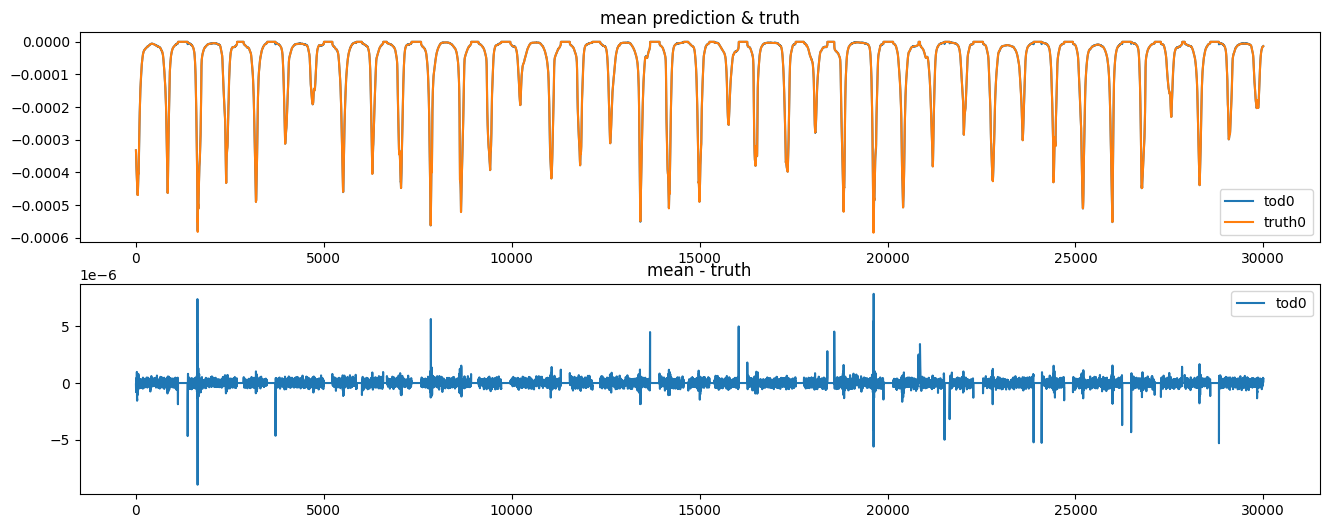

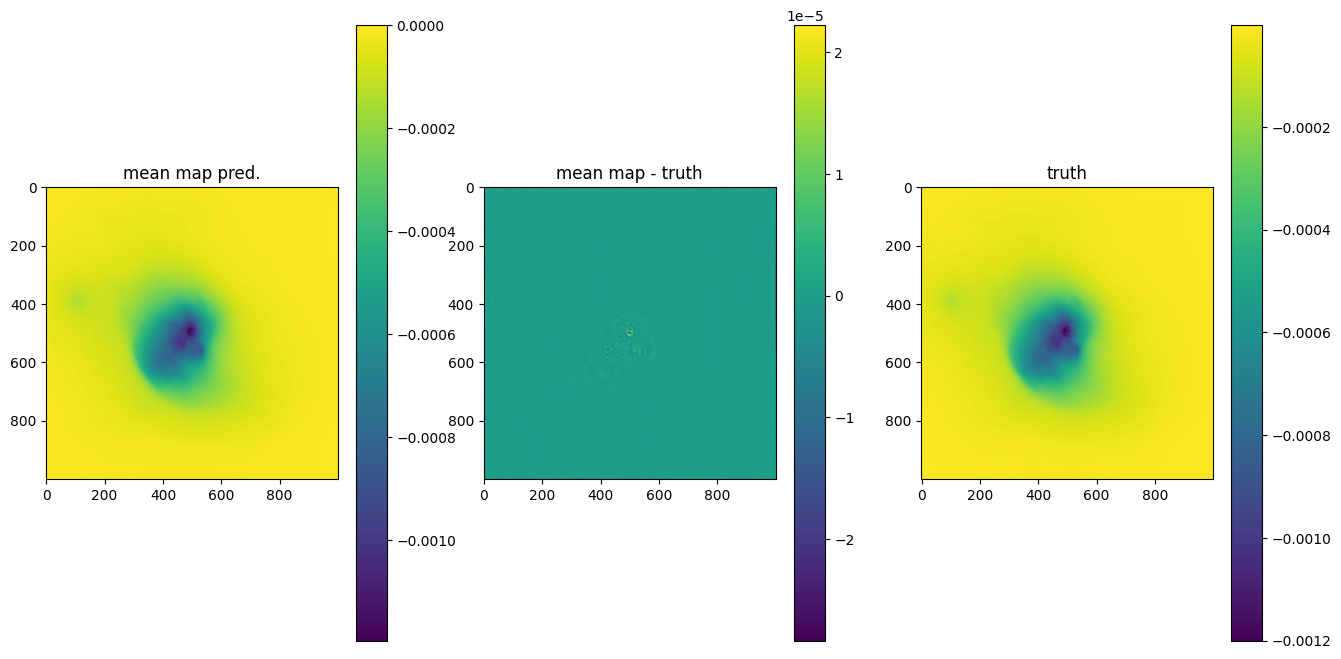

OPTIMIZE_KL: Starting 0006
SL: Iteration 0 ⛰:+4.1559e+14 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:+3.7221e+10 Δ⛰:4.1555e+14 ➽:1.0000e+01
SL: Iteration 2 ⛰:+1.5885e+10 Δ⛰:2.1335e+10 ➽:1.0000e+01
SL: Iteration 3 ⛰:+1.1417e+10 Δ⛰:4.4681e+09 ➽:1.0000e+01
SL: Iteration 4 ⛰:+8.9123e+09 Δ⛰:2.5050e+09 ➽:1.0000e+01
SL: Iteration 5 ⛰:+8.8670e+09 Δ⛰:4.5334e+07 ➽:1.0000e+01
SL: Iteration 6 ⛰:+7.6235e+09 Δ⛰:1.2435e+09 ➽:1.0000e+01
SL: Iteration 7 ⛰:+7.2397e+09 Δ⛰:3.8386e+08 ➽:1.0000e+01
SL: Iteration 8 ⛰:+7.2332e+09 Δ⛰:6.5163e+06 ➽:1.0000e+01
SL: Iteration 9 ⛰:+7.2328e+09 Δ⛰:3.7301e+05 ➽:1.0000e+01
SL: Iteration 10 ⛰:+6.0836e+09 Δ⛰:1.1492e+09 ➽:1.0000e+01
SL: Iteration 11 ⛰:+5.5834e+09 Δ⛰:5.0027e+08 ➽:1.0000e+01
SL: Iteration 12 ⛰:+5.3825e+09 Δ⛰:2.0083e+08 ➽:1.0000e+01
SL: Iteration 13 ⛰:+5.3825e+09 Δ⛰:1.1715e+04 ➽:1.0000e+01
SL: Iteration 14 ⛰:+5.1521e+09 Δ⛰:2.3040e+08 ➽:1.0000e+01
SL: Iteration 15 ⛰:+5.1517e+09 Δ⛰:3.8432e+05 ➽:1.0000e+01
SL: Iteration 16 ⛰:+4.6857e+09 Δ⛰:4.6603e+08 ➽:1.0000e+01
SL: 

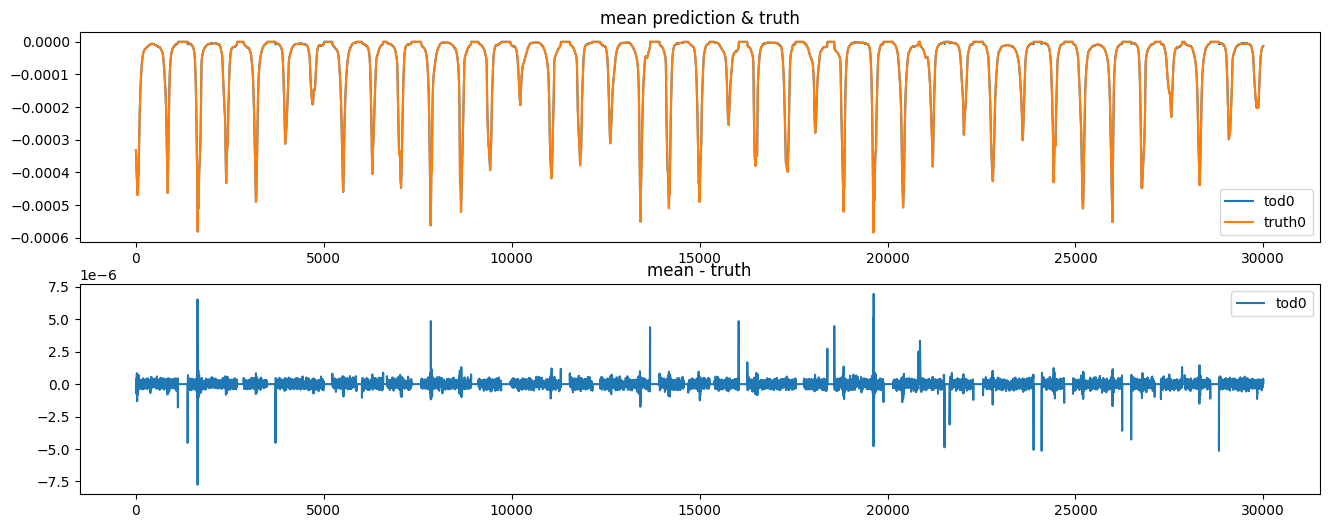

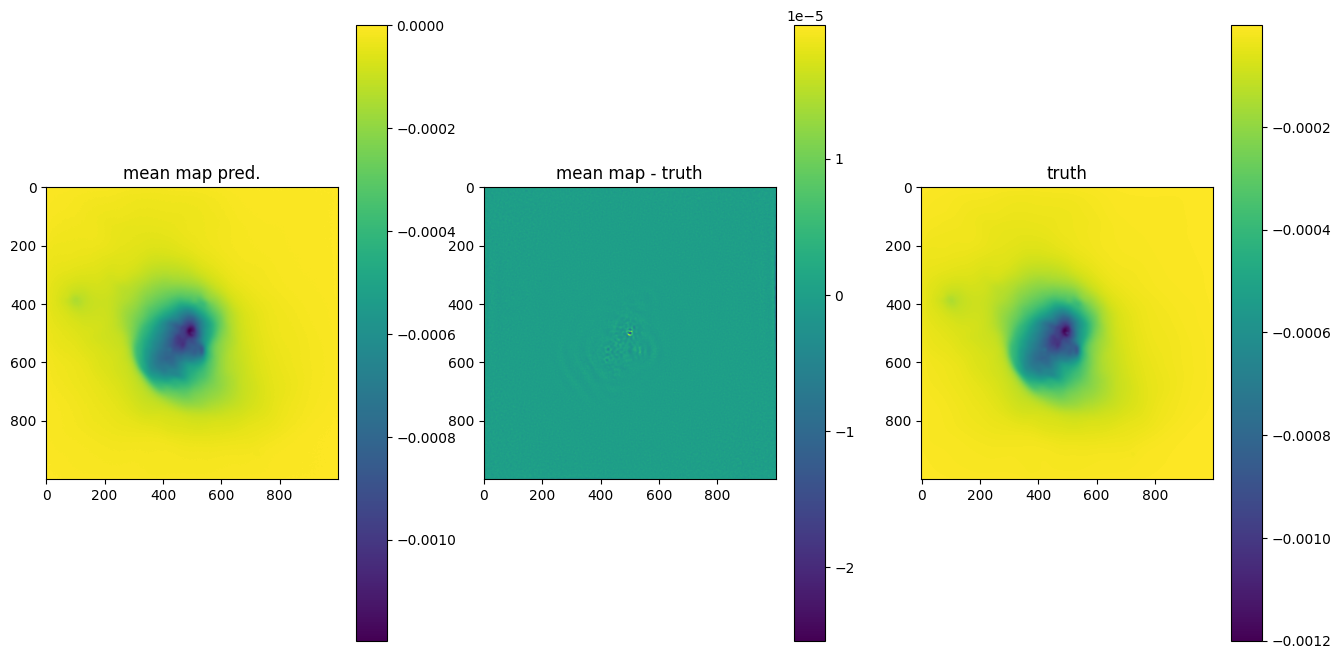

OPTIMIZE_KL: Starting 0007
SL: Iteration 0 ⛰:+1.3515e+13 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:+5.6058e+12 Δ⛰:7.9094e+12 ➽:1.0000e+01
SL: Iteration 2 ⛰:+1.7958e+10 Δ⛰:5.5878e+12 ➽:1.0000e+01
SL: Iteration 3 ⛰:+1.1134e+10 Δ⛰:6.8233e+09 ➽:1.0000e+01
SL: Iteration 4 ⛰:+8.9181e+09 Δ⛰:2.2164e+09 ➽:1.0000e+01
SL: Iteration 5 ⛰:+8.8931e+09 Δ⛰:2.5022e+07 ➽:1.0000e+01
SL: Iteration 6 ⛰:+7.6007e+09 Δ⛰:1.2923e+09 ➽:1.0000e+01
SL: Iteration 7 ⛰:+6.5720e+09 Δ⛰:1.0288e+09 ➽:1.0000e+01
SL: Iteration 8 ⛰:+6.5691e+09 Δ⛰:2.8563e+06 ➽:1.0000e+01
SL: Iteration 9 ⛰:+6.5691e+09 Δ⛰:2.5748e+03 ➽:1.0000e+01
SL: Iteration 10 ⛰:+5.8188e+09 Δ⛰:7.5028e+08 ➽:1.0000e+01
SL: Iteration 11 ⛰:+5.2764e+09 Δ⛰:5.4248e+08 ➽:1.0000e+01
SL: Iteration 12 ⛰:+5.0254e+09 Δ⛰:2.5093e+08 ➽:1.0000e+01
SL: Iteration 13 ⛰:+5.0129e+09 Δ⛰:1.2558e+07 ➽:1.0000e+01
SL: Iteration 14 ⛰:+4.6131e+09 Δ⛰:3.9982e+08 ➽:1.0000e+01
SL: Iteration 15 ⛰:+4.5935e+09 Δ⛰:1.9533e+07 ➽:1.0000e+01
SL: Iteration 16 ⛰:+4.4164e+09 Δ⛰:1.7714e+08 ➽:1.0000e+01
SL: 

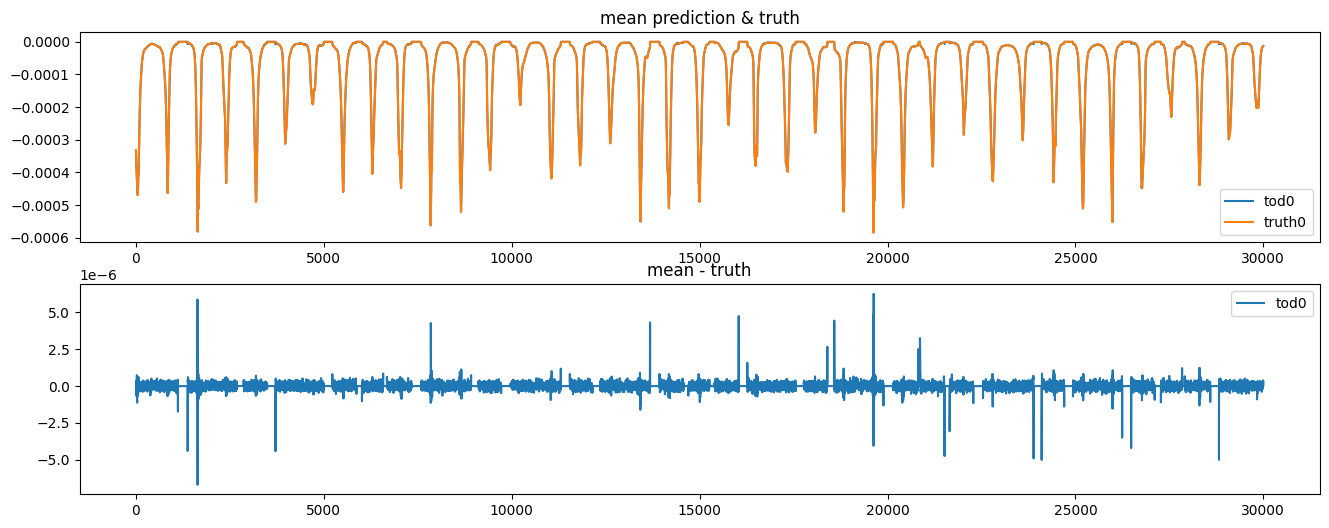

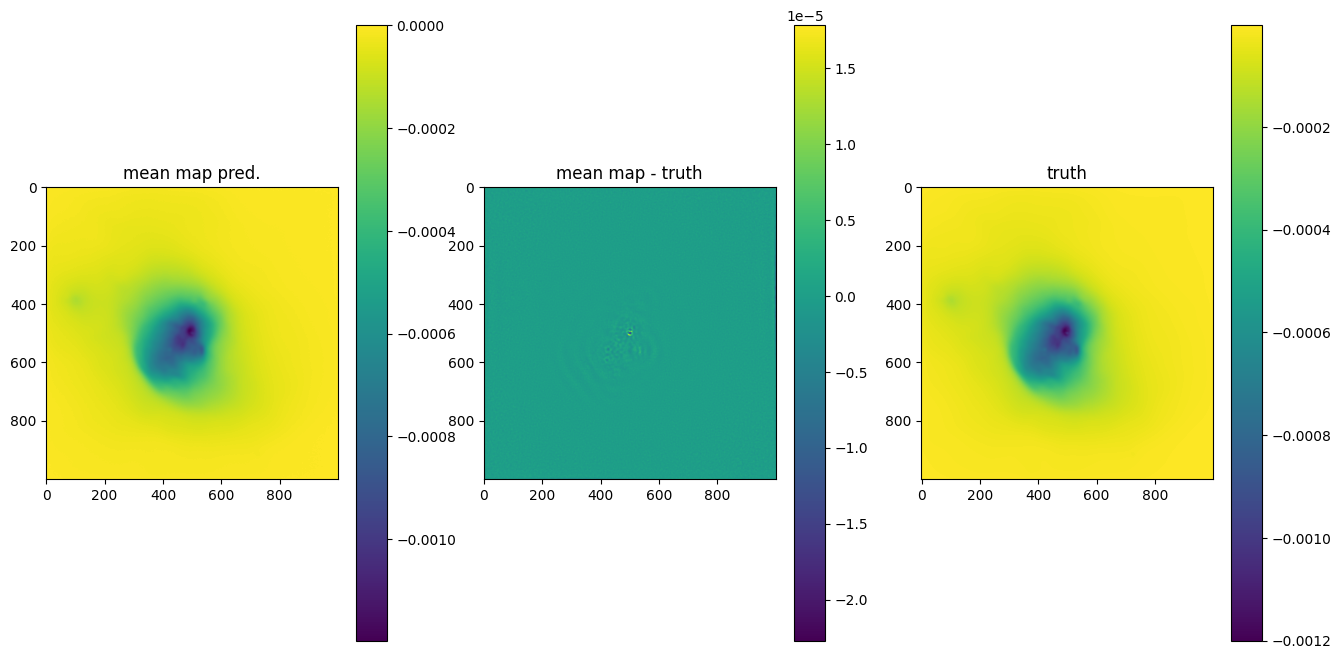

OPTIMIZE_KL: Starting 0008
SL: Iteration 0 ⛰:+2.0861e+14 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:+6.8587e+11 Δ⛰:2.0792e+14 ➽:1.0000e+01
SL: Iteration 2 ⛰:+1.3758e+10 Δ⛰:6.7211e+11 ➽:1.0000e+01
SL: Iteration 3 ⛰:+1.0682e+10 Δ⛰:3.0760e+09 ➽:1.0000e+01
SL: Iteration 4 ⛰:+8.5932e+09 Δ⛰:2.0886e+09 ➽:1.0000e+01
SL: Iteration 5 ⛰:+8.1934e+09 Δ⛰:3.9986e+08 ➽:1.0000e+01
SL: Iteration 6 ⛰:+6.8657e+09 Δ⛰:1.3276e+09 ➽:1.0000e+01
SL: Iteration 7 ⛰:+6.8298e+09 Δ⛰:3.5914e+07 ➽:1.0000e+01
SL: Iteration 8 ⛰:+6.0872e+09 Δ⛰:7.4264e+08 ➽:1.0000e+01
SL: Iteration 9 ⛰:+6.0872e+09 Δ⛰:8.7481e+03 ➽:1.0000e+01
SL: Iteration 10 ⛰:+5.6469e+09 Δ⛰:4.4022e+08 ➽:1.0000e+01
SL: Iteration 11 ⛰:+5.3304e+09 Δ⛰:3.1659e+08 ➽:1.0000e+01
SL: Iteration 12 ⛰:+5.0802e+09 Δ⛰:2.5015e+08 ➽:1.0000e+01
SL: Iteration 13 ⛰:+5.0798e+09 Δ⛰:4.5239e+05 ➽:1.0000e+01
SL: Iteration 14 ⛰:+4.6834e+09 Δ⛰:3.9634e+08 ➽:1.0000e+01
SL: Iteration 15 ⛰:+4.6821e+09 Δ⛰:1.2982e+06 ➽:1.0000e+01
SL: Iteration 16 ⛰:+4.3661e+09 Δ⛰:3.1605e+08 ➽:1.0000e+01
SL: 

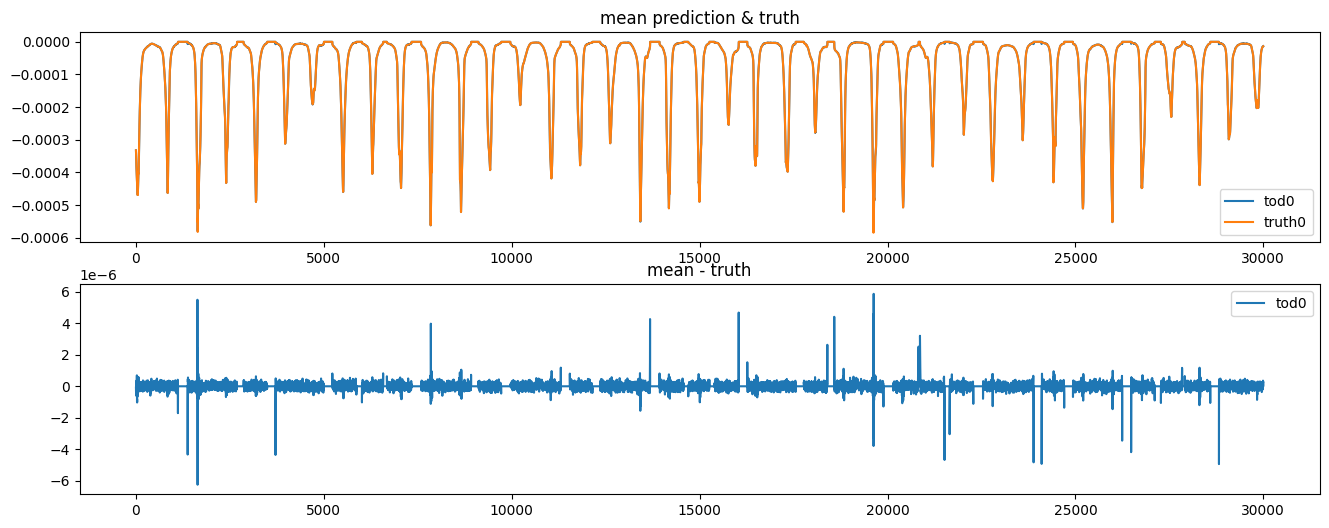

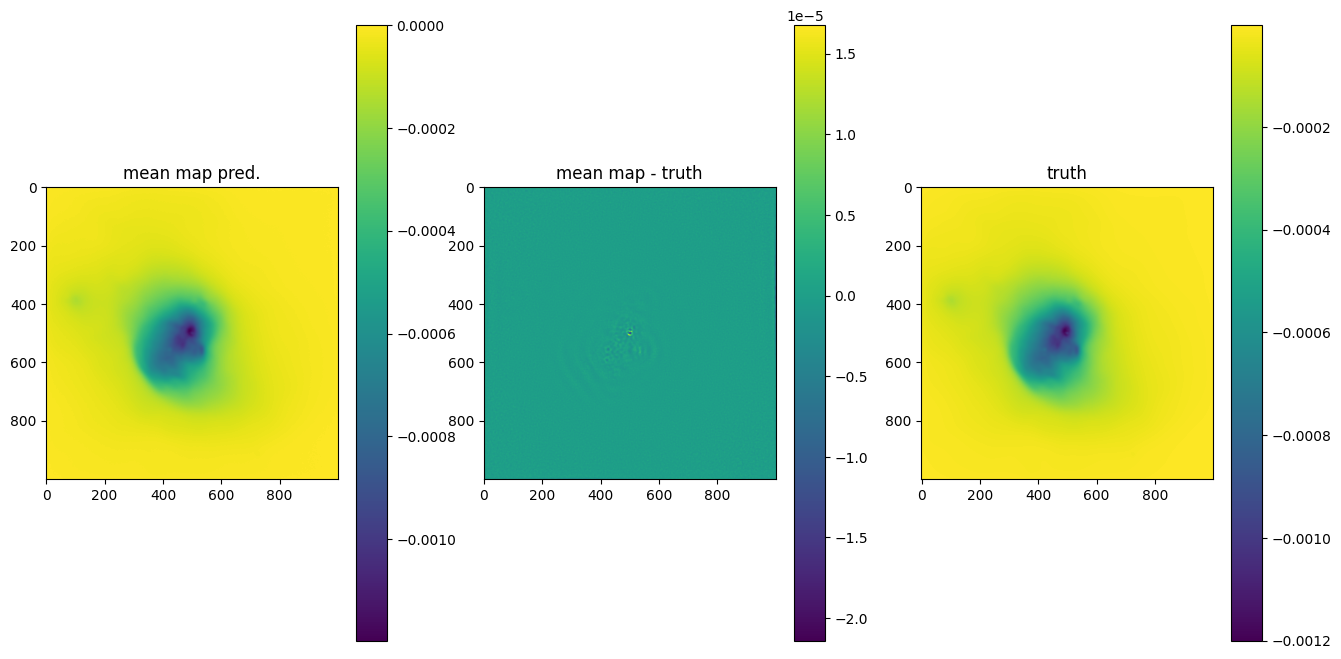

OPTIMIZE_KL: Starting 0009
SL: Iteration 0 ⛰:+3.7215e+14 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:+3.7253e+10 Δ⛰:3.7211e+14 ➽:1.0000e+01
SL: Iteration 2 ⛰:+1.7375e+10 Δ⛰:1.9877e+10 ➽:1.0000e+01
SL: Iteration 3 ⛰:+1.0600e+10 Δ⛰:6.7749e+09 ➽:1.0000e+01
SL: Iteration 4 ⛰:+8.1309e+09 Δ⛰:2.4696e+09 ➽:1.0000e+01
SL: Iteration 5 ⛰:+8.1309e+09 Δ⛰:2.0665e+04 ➽:1.0000e+01
SL: Iteration 6 ⛰:+7.2197e+09 Δ⛰:9.1117e+08 ➽:1.0000e+01
SL: Iteration 7 ⛰:+6.4607e+09 Δ⛰:7.5902e+08 ➽:1.0000e+01
SL: Iteration 8 ⛰:+6.4237e+09 Δ⛰:3.6996e+07 ➽:1.0000e+01
SL: Iteration 9 ⛰:+6.4056e+09 Δ⛰:1.8070e+07 ➽:1.0000e+01
SL: Iteration 10 ⛰:+5.5381e+09 Δ⛰:8.6747e+08 ➽:1.0000e+01
SL: Iteration 11 ⛰:+5.1577e+09 Δ⛰:3.8047e+08 ➽:1.0000e+01
SL: Iteration 12 ⛰:+4.7438e+09 Δ⛰:4.1383e+08 ➽:1.0000e+01
SL: Iteration 13 ⛰:+4.7438e+09 Δ⛰:6.6823e+03 ➽:1.0000e+01
SL: Iteration 14 ⛰:+4.5031e+09 Δ⛰:2.4071e+08 ➽:1.0000e+01
SL: Iteration 15 ⛰:+4.4932e+09 Δ⛰:9.9572e+06 ➽:1.0000e+01
SL: Iteration 16 ⛰:+4.2308e+09 Δ⛰:2.6236e+08 ➽:1.0000e+01
SL: 

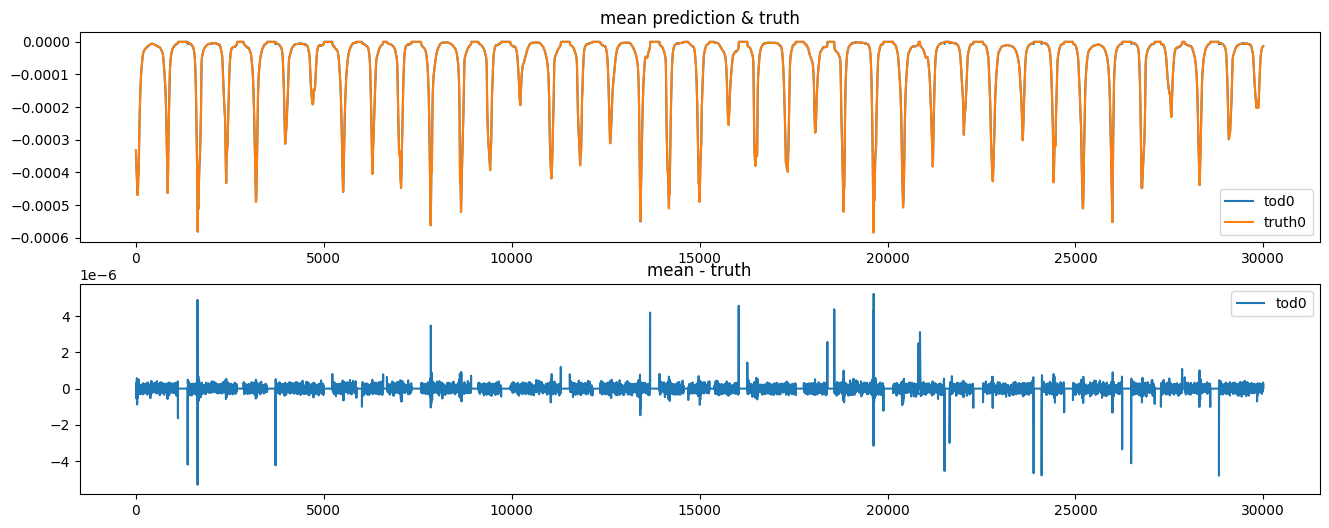

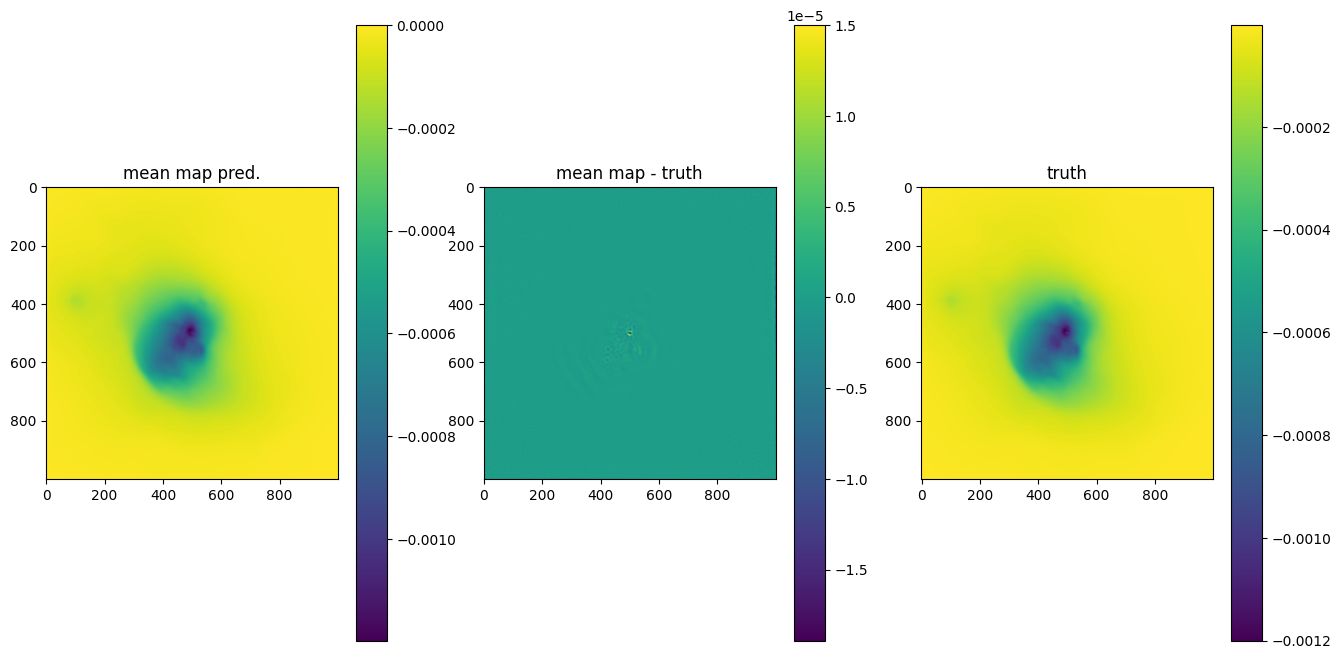

OPTIMIZE_KL: Starting 0010
SL: Iteration 0 ⛰:+5.9257e+13 Δ⛰:inf ➽:1.0000e+01
SL: Iteration 1 ⛰:+1.8998e+12 Δ⛰:5.7358e+13 ➽:1.0000e+01
SL: Iteration 2 ⛰:+1.5630e+10 Δ⛰:1.8841e+12 ➽:1.0000e+01
SL: Iteration 3 ⛰:+9.7573e+09 Δ⛰:5.8729e+09 ➽:1.0000e+01
SL: Iteration 4 ⛰:+7.5970e+09 Δ⛰:2.1603e+09 ➽:1.0000e+01
SL: Iteration 5 ⛰:+7.5900e+09 Δ⛰:6.9735e+06 ➽:1.0000e+01
SL: Iteration 6 ⛰:+6.8536e+09 Δ⛰:7.3642e+08 ➽:1.0000e+01
SL: Iteration 7 ⛰:+6.6478e+09 Δ⛰:2.0579e+08 ➽:1.0000e+01
SL: Iteration 8 ⛰:+5.9836e+09 Δ⛰:6.6419e+08 ➽:1.0000e+01
SL: Iteration 9 ⛰:+5.8542e+09 Δ⛰:1.2944e+08 ➽:1.0000e+01
SL: Iteration 10 ⛰:+5.2964e+09 Δ⛰:5.5778e+08 ➽:1.0000e+01
SL: Iteration 11 ⛰:+4.8790e+09 Δ⛰:4.1739e+08 ➽:1.0000e+01
SL: Iteration 12 ⛰:+4.7324e+09 Δ⛰:1.4657e+08 ➽:1.0000e+01
SL: Iteration 13 ⛰:+4.7323e+09 Δ⛰:1.4367e+05 ➽:1.0000e+01
SL: Iteration 14 ⛰:+4.7094e+09 Δ⛰:2.2877e+07 ➽:1.0000e+01
SL: Iteration 15 ⛰:+4.2927e+09 Δ⛰:4.1673e+08 ➽:1.0000e+01
SL: Iteration 16 ⛰:+3.9725e+09 Δ⛰:3.2016e+08 ➽:1.0000e+01
SL: 

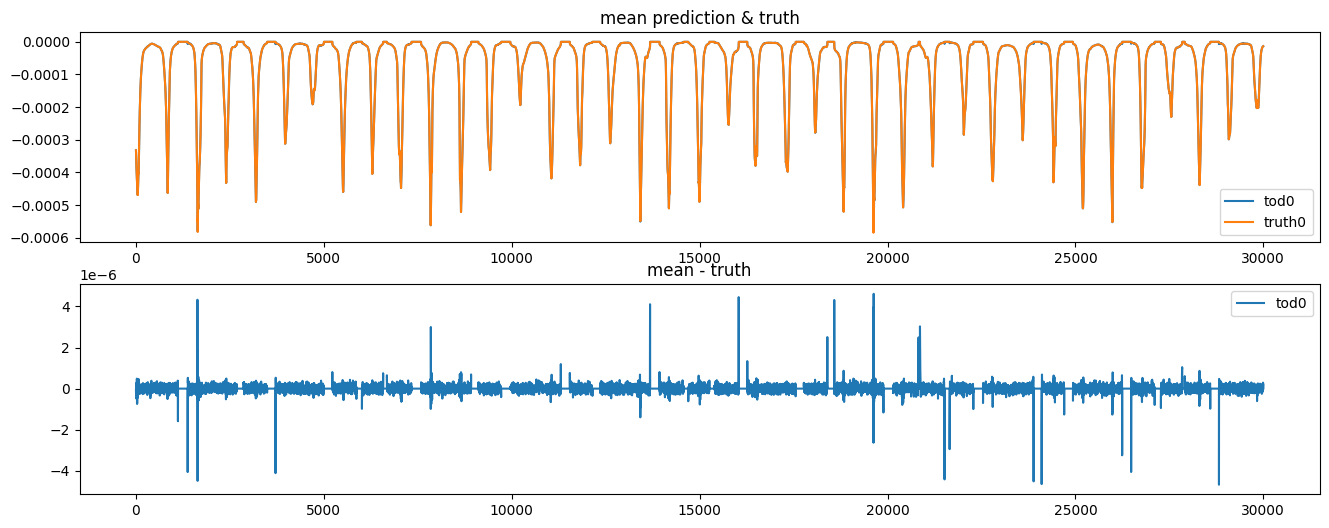

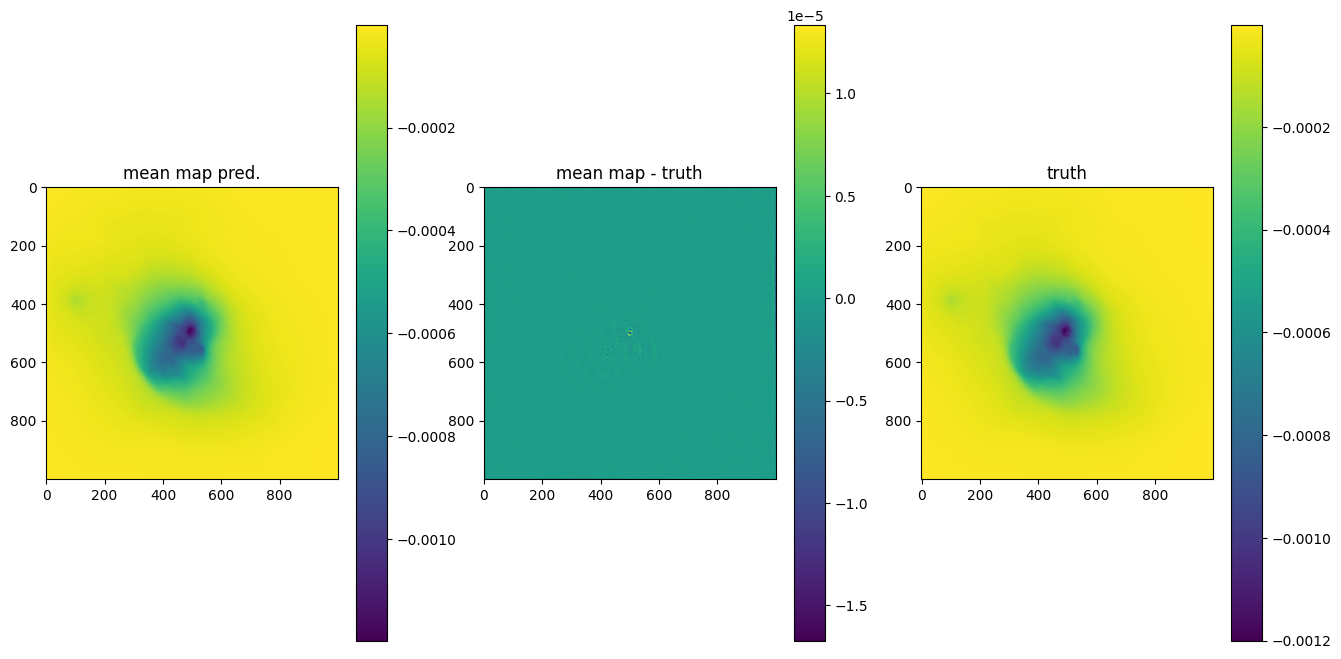

In [49]:
n_it = 10
# n_it = 20
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
# if noiselevel == 0.0: delta = 1e-6
if noiselevel == 0.0: delta = 1e-4
# if noiselevel == 0.0: delta = 1e-11
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4
n_samples = 4 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

# callback fn for plotting during optimisation:
def callback(samples, opt_state):
    mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

    fig_tods, axes_tods = plt.subplots(2, 1, figsize=(16, 6))

    # for i in range(0, mean.shape[0], mean.shape[0]//10):
    for i in range(n):
        axes_tods[0].plot(np.arange(0, mean.shape[1]), mean[i], label=f"tod{i}")
        axes_tods[0].plot(truth[i], label=f"truth{i}")
        axes_tods[1].plot(np.arange(0, mean.shape[1]), mean[i] - truth[i], label=f"tod{i}")

    axes_tods[0].title.set_text('mean prediction & truth')
    axes_tods[0].legend()
    axes_tods[1].title.set_text('mean - truth')
    axes_tods[1].legend()

    fig_map, axes_map = plt.subplots(1, 3, figsize=(16, 8))

    mean_map, _ = jft.mean_and_std(tuple(gp_map(s) for s in samples))

    im0 = axes_map[0].imshow(mean_map)
    axes_map[0].title.set_text('mean map pred.')
    fig_map.colorbar(im0)

    im1 = axes_map[1].imshow(mean_map - mapdata_truth[0])
    axes_map[1].title.set_text('mean map - truth')
    fig_map.colorbar(im1)

    im2 = axes_map[2].imshow(mapdata_truth[0])
    axes_map[2].title.set_text('truth')
    fig_map.colorbar(im2)

    plt.show()
    

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
        # cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=10),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=10
        )
    ),
    # sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
    sample_mode = lambda x: "nonlinear_resample" if x >= 1 else "linear_resample",
    callback=callback,
)

In [50]:
printfitresults()

Fit Results (res, init, std)
map:
	fluctuations: 1.7866837858843995e-06, 1e-06, 1e-06
	loglogvarslope: -2.4706591478827042, -2.5, 0.5
	zeromode std (LogNormal): 3.2909791869164777e-10, 1e-08, 1e-07


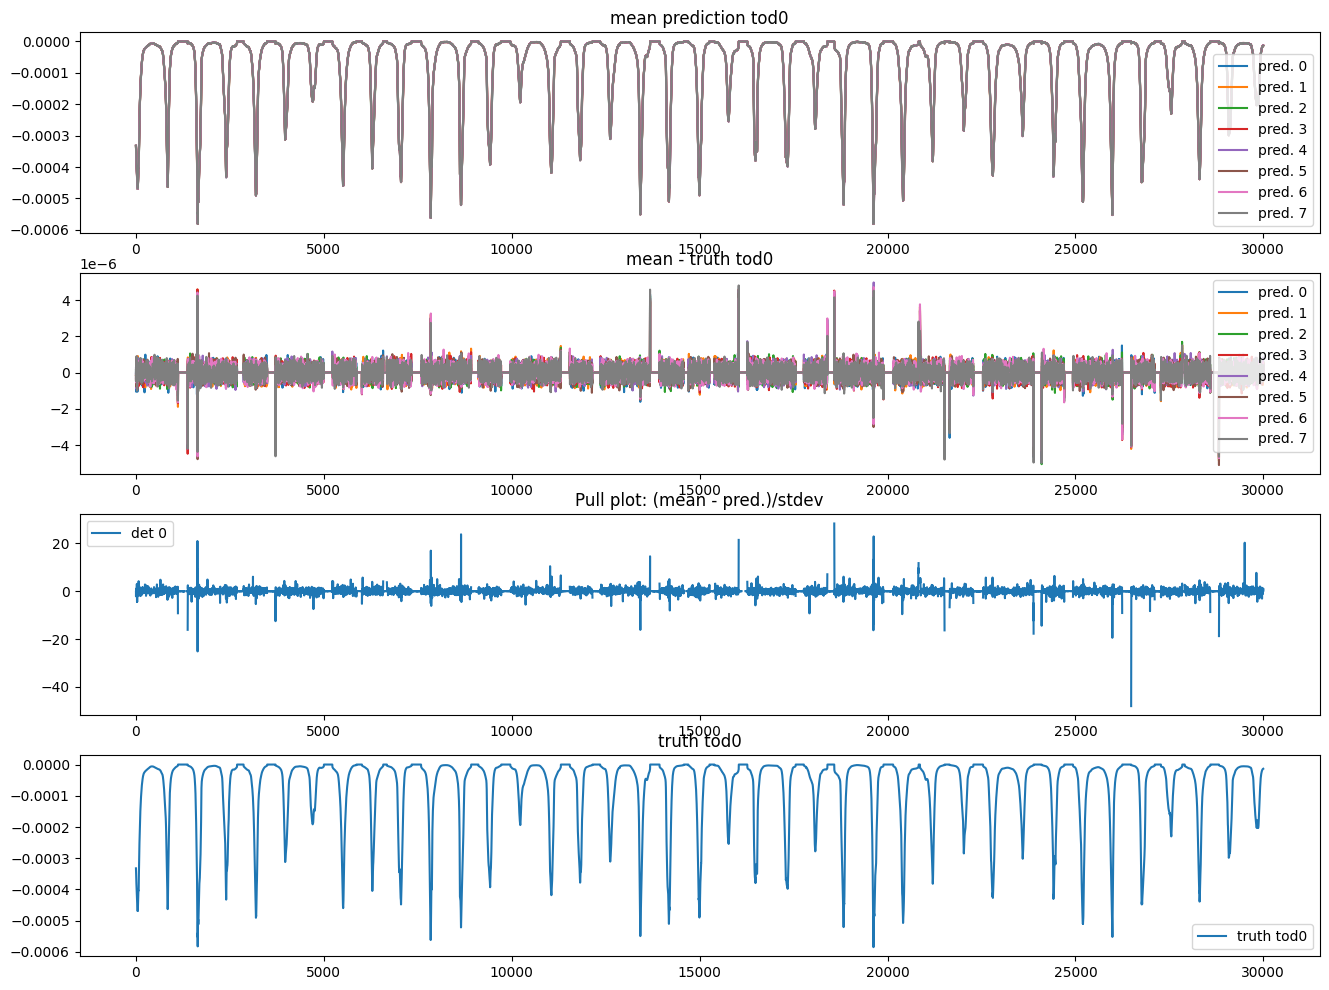

In [51]:
mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
i = 0
j = 0
# for i in range(mean.shape[0]):
for s in samples:
    pred = signal_response_tod(s)
    
    im0 = axes[0].plot(np.arange(0, pred.shape[1]), pred[i], label=f"pred. {j}")
    im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - truth[i], label=f"pred. {j}")
    j += 1

im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - truth[i])/std[i], label=f"det {i}")
im3 = axes[3].plot(truth[i], label=f"truth tod{i}")
axes[0].title.set_text(f"mean prediction tod{i}")
axes[0].legend()
axes[1].title.set_text(f"mean - truth tod{i}")
axes[1].legend()
axes[2].title.set_text(f"Pull plot: (mean - pred.)/stdev")
axes[2].legend()
axes[3].title.set_text(f"truth tod{i}")
axes[3].legend()

plt.show()